## 1. File description 




## 0. Import module and setting notebook preferences

### 0.1 Import modules

In [29]:
import src.useful as su
import src.labelling as sl
import src.image as si
import src.model as sm 
import src.webscraping as sw
import src.viz as sv

import sqlite3
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import boxcox

import nltk 
from nltk.corpus import stopwords
from collections import Counter


import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
import dtale
# from autoviz import data_cleaning_suggestions


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import re
import os
from pandarallel import pandarallel
from tqdm import tqdm
from tabulate import tabulate

pandarallel.initialize()
sl.Mypandas.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### 0.2 Notebook preferences

In [30]:
# Setting pandas options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,}'.format

# Setting plotly as dark
pio.templates.default = "plotly_dark"
plotly_kwargs = {'category_orders': {"label": [0, 1, 2, 3]},
                 'color_discrete_sequence': ['#1f77b4', '#EF553B', '#00CC96', '#FECB52']}

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

# Setting path to export viz
viz_dir = '/Users/marclamy/Desktop/code/viz/instabot/'

# Creating empty README.md file with all viz links
with open('/Users/marclamy/Desktop/code/viz/README.md', 'w') as f:
    f.write('### Instabot project\n\n')

### 0.3 Load and consolidate the data into a single table


In [31]:
def get_main():
    df_main = sl.load_main()
    df_labels = sl.load_labels()
    
    df_main = df_main.merge(df_labels, how='left', on='username')

    # either fillna, either dropna, depending on the use case, comment/uncomment
    # df_main['label'] = df_main['label'].fillna(-1).astype(int)
    # df_main['label'] = df_main['label'].astype(str)

    df_main = df_main.dropna(subset='label').reset_index(drop=True)
    df_main['label'] = df_main['label'].astype(int)
    df_main['binary_label'] = df_main['label'].apply(lambda x: 1 if x == 3 else x).astype(int)

    # df_main = sl.Mypandas(df_main)


    # df_main = df_main.drop([col for col in df_main.columns if any([f'posts_{x}' in col for x in ['sum', 'min', 'max', 'avg', 'concat']])], axis=1)
    return df_main 

df_main = get_main()
df_main_bu = df_main.copy(deep=True)
df_main.head()

username  \
0       adorable-jade-beluga   
1  hysterical-glistening-bee   
2         little-crafty-mink   
3        gentle-crimson-wolf   
4       festive-uppish-leech   

                                           biography  \
0  ⁣⁣28 🇩🇪 🇪🇸 \nCapricorn 🐐 \nDallas TX📍Outside 🍾...   
1  “Moving at a pace slow for some but fast for o...   
2                                          New Page.   
3                                         • 9/26 💘 •   
4                                       Stay mad bum   

                                  biography_wo_emoji biography_emoji  \
0  ⁣⁣28   \nCapricorn  \nDallas TXOutside \n“Her ...        🇩🇪🇪🇸🚫🍾📍🐐   
1  “Moving at a pace slow for some but fast for o...             ⬇️🚨   
2                                          New Page.                   
3                                          • 9/26  •               💘   
4                                       Stay mad bum                   

   biography_emoji_count  biography_emoji_count_distinct  follow_count  \
0                    6.0                             6.0       3,164.0   
1                    2.0                             2.0         114.0   
2                    0.0                             0.0         204.0   
3                    1.0                             1.0         211.0   
4                    0.0                             0.0           0.0   

   follower_count pronouns           domain  \
0         4,676.0     None  mintyswraps.com   
1            52.0     None      youtube.com   
2           422.0     None             None   
3           586.0     None             None   
4             0.0     None             None   

                                             comment  \
0                      Bucks finna have a repeat 🏆 👀   
1                       CRAZY EYES GOT MOVES LOL 🤣🤣😭   
2                        Flight is gonna be heated 😂   
3  Someone forgot to tell the warriors they had a...   
4                      Klay is back scary hoursss 🤪🤪   

                                    comment_wo_emoji comment_emoji  \
0                          Bucks finna have a repeat            👀🏆   
1                           CRAZY EYES GOT MOVES LOL            🤣😭   
2                          Flight is gonna be heated             😂   
3  Someone forgot to tell the warriors they had a...             😂   
4                         Klay is back scary hoursss             🤪   

   comment_emoji_count  comment_emoji_count_distinct  comment_time_difference  \
0                    2                             2                       95   
1                    3                             2                      250   
2                    1                             1                      310   
3                    1                             1                      180   
4                    2                             1                      245   

   comment_likes  post_count  video_count  highlight_reel_count  \
0            967        76.0          6.0                   8.0   
1           1024         0.0          2.0                   0.0   
2            711         0.0          0.0                   0.0   
3            161         6.0          0.0                   0.0   
4            166         0.0          0.0                   0.0   

   hide_like_and_view_counts  has_guides  has_clips  is_private  \
0                        0.0         0.0        1.0         0.0   
1                        0.0         0.0        1.0         0.0   
2                        1.0         0.0        0.0         1.0   
3                        0.0         0.0        0.0         0.0   
4                        0.0         0.0        0.0         1.0   

   is_embeds_disabled  is_joined_recently  is_professional_account  \
0                 0.0                 0.0                      0.0   
1                 0.0                 0.0                      1.0   
2                 0.0                 0.0                      0.0  

In [32]:
pd.read_sql_query('select * from comments', con).shape

(134465, 12)

### 0.3 Split data for the steps that will need feature engineering without introducint data leakage

In [33]:
X = df_main.drop('label', axis=1)
y = df_main['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
os.system('say "error"')

0

### 0.4 Counting labels

In [35]:
unique_comments = df_main.shape[0]
unique_usernames = df_main.drop_duplicates(subset='username').shape[0]

labels = df_main['label'].value_counts()
labels_unique = df_main.drop_duplicates(subset='username')['label'].value_counts()


print(f'{unique_comments = }')
print(f'{unique_usernames = }\n')
print(f'Labels for comment \n{labels}\n')
print(f'Labels unique users \n{labels_unique}\n\n')
print(f'% comments labelled: {sum(labels)/unique_comments:.1%}')
print(f'% users labelled: {sum(labels_unique)/unique_usernames:.1%}')

unique_comments = 30420
unique_usernames = 14571

Labels for comment 
0    18553
1    10928
3      939
Name: label, dtype: int64

Labels unique users 
0    11225
1     2863
3      483
Name: label, dtype: int64


% comments labelled: 100.0%
% users labelled: 100.0%


## 1.0 Quick viz - Move this to part 2 for when the data is clean

### 1.X Pandas profiling

In [36]:
# Generate report of the data
# profile = ProfileReport(df_main, title="Pandas Profiling Report")
# profile.to_file('data/pandas_profiling.html')

In [37]:
df_main.head()

username  \
0       adorable-jade-beluga   
1  hysterical-glistening-bee   
2         little-crafty-mink   
3        gentle-crimson-wolf   
4       festive-uppish-leech   

                                           biography  \
0  ⁣⁣28 🇩🇪 🇪🇸 \nCapricorn 🐐 \nDallas TX📍Outside 🍾...   
1  “Moving at a pace slow for some but fast for o...   
2                                          New Page.   
3                                         • 9/26 💘 •   
4                                       Stay mad bum   

                                  biography_wo_emoji biography_emoji  \
0  ⁣⁣28   \nCapricorn  \nDallas TXOutside \n“Her ...        🇩🇪🇪🇸🚫🍾📍🐐   
1  “Moving at a pace slow for some but fast for o...             ⬇️🚨   
2                                          New Page.                   
3                                          • 9/26  •               💘   
4                                       Stay mad bum                   

   biography_emoji_count  biography_emoji_count_distinct  follow_count  \
0                    6.0                             6.0       3,164.0   
1                    2.0                             2.0         114.0   
2                    0.0                             0.0         204.0   
3                    1.0                             1.0         211.0   
4                    0.0                             0.0           0.0   

   follower_count pronouns           domain  \
0         4,676.0     None  mintyswraps.com   
1            52.0     None      youtube.com   
2           422.0     None             None   
3           586.0     None             None   
4             0.0     None             None   

                                             comment  \
0                      Bucks finna have a repeat 🏆 👀   
1                       CRAZY EYES GOT MOVES LOL 🤣🤣😭   
2                        Flight is gonna be heated 😂   
3  Someone forgot to tell the warriors they had a...   
4                      Klay is back scary hoursss 🤪🤪   

                                    comment_wo_emoji comment_emoji  \
0                          Bucks finna have a repeat            👀🏆   
1                           CRAZY EYES GOT MOVES LOL            🤣😭   
2                          Flight is gonna be heated             😂   
3  Someone forgot to tell the warriors they had a...             😂   
4                         Klay is back scary hoursss             🤪   

   comment_emoji_count  comment_emoji_count_distinct  comment_time_difference  \
0                    2                             2                       95   
1                    3                             2                      250   
2                    1                             1                      310   
3                    1                             1                      180   
4                    2                             1                      245   

   comment_likes  post_count  video_count  highlight_reel_count  \
0            967        76.0          6.0                   8.0   
1           1024         0.0          2.0                   0.0   
2            711         0.0          0.0                   0.0   
3            161         6.0          0.0                   0.0   
4            166         0.0          0.0                   0.0   

   hide_like_and_view_counts  has_guides  has_clips  is_private  \
0                        0.0         0.0        1.0         0.0   
1                        0.0         0.0        1.0         0.0   
2                        1.0         0.0        0.0         1.0   
3                        0.0         0.0        0.0         0.0   
4                        0.0         0.0        0.0         1.0   

   is_embeds_disabled  is_joined_recently  is_professional_account  \
0                 0.0                 0.0                      0.0   
1                 0.0                 0.0                      1.0   
2                 0.0                 0.0                      0.0  

### 1.X dtale

In [38]:
# dtale.show(df_main)

### 1.x Autoviz

In [39]:
os.system('say "auto viz done"')

0

## 1.0 Data cleaning and Univariate Analysis

For the following: 
* Clean the column 
    * Remove missing value/add a missing flag column
    * Flag and remove outliers
* Add new features
* Data viz
    * Look at the distribution for each label
    * Look at describe per label 
    * Next to the title, add - Done / - missing markdown
---


Sub groups of 1.0 with: 
* Biography 
    * bio/bio wo emoji 
    * bio emoji count 
* Comment 
    * Comment/wo emoji
    * Comment int cols 
* Follow/er count 
* Domain
* Post/video count 
    * and highlight_reel_count
* Binary
    * hide like and view count 
    * has guides 
    * has clips 
    * is private 
    * is embeds 
    * is joined 
    * is verified
* Professional/business account 
* Posts list
* Dates diff 


### 1.0.1 Functions - add in my pandas or src files?

In [40]:
df_main['outlier'] = ''
def print_outliers(df, col, threshold=None):
    '''Calculating outliers and flagging them'''
    lower_bound, upper_bound = df.outliers_bound(col)
    df['outlier'] = df.apply(lambda x: x['outlier'] if lower_bound < x[col] < upper_bound else x['outlier'] + ', ' + col, axis=1)
    print(f'Lower bound: {lower_bound} - Upper bound: {upper_bound}\n')
    print(df.query(f'{col} >= @upper_bound').shape[0], 'outliers found\n')

    # Checking outliers per label 
    for label in (0, 1, 3):
        print(f'Label: {label}')
        display(df.query(f'label == {label}')[col].apply(lambda x: lower_bound <= x <= upper_bound).value_counts().reset_index().rename(columns={'index': 'Condition', col: 'Count'}).assign(Percentage=lambda x: (x['Count']/x['Count'].sum()*100).round(1)))
    
    return df

In [41]:
def split_value_count(df, col, label=None):
    if label != None: 
        df = df.query(f'label == {label}')
    # print(df.shape, label)
    val_count = df[col].value_counts().sort_index()
    no = val_count[0] if 0 in val_count.index else 0
    yes = val_count[1] if 1 in val_count.index else 0
    no_norm = (no / (yes + no) * 100).round(2) 
    yes_norm = (yes / (yes + no) * 100).round(2)
    return yes, no, yes_norm, no_norm


def plot_binary_distribution_by_label(df, col, title=None):
    if title == None: 
        f'Distribution of {col.title()} by Labels'
        
    labels = df['label'].unique()

    # create a dictionary to map label to subplot index
    label_subplot_dict = {label: i+1 for i, label in enumerate(labels)}

    # create figure with 2 rows and 3 columns (top chart uses 3 columns)
    fig = make_subplots(rows=2, cols=len(labels), 
                    specs=[[None] + [{'rowspan': 1, 'colspan': 1}] + [None],
                        [{'rowspan': 1, 'colspan': 1} for label in labels]],
                        subplot_titles=['All Labels'] + [f'Label {label}' for label in labels],
                    x_title='Your master x-title',
                    y_title='Your master y-title', 
                    shared_yaxes=True)


    # Adding all data regardless of label
    yes, no, yes_norm, no_norm = split_value_count(df, col)
    fig.add_trace(go.Bar(name='All Labels', 
                            x=df[col].astype(str).sort_values().unique(), 
                            y=[no_norm, yes_norm], 
                            text=[no_norm, yes_norm]), 
                    row=1, col=2)
    

    subplot_titles=[f'All Labels: n={no:,} / y={yes:,}']
    # label subplots
    for label in df['label'].unique():
        yes, no, yes_norm, no_norm = split_value_count(df, col, label)
        subplot_titles.append(f'Label {label} - n={no:,} / y={yes:,}')

        # Adding trace for label
        fig.add_trace(go.Bar(name=f'Label {label}', 
                            x=df[col].astype(str).sort_values().unique(), 
                            y=[no_norm, yes_norm], 
                            text=[no_norm, yes_norm]), 
                                
                        row=2, col=label_subplot_dict[label])

    fig.update_layout(height=800, 
                      title=title)
    
    subplot_titles += [''] + [''] # This is for the x and y main axis titles
    fig.update_layout(annotations=[{'text': name} for name in subplot_titles])

    return fig

In [42]:
os.system('say "import good"')
asdflkj

NameError: name 'asdflkj' is not defined

### 1.1 Comments - Done ✅

#### 1.1.0 Gram functions

Creating functions to clean/calculate/show different grams of the comments. Will be reusing them for biography.

In [ ]:
def clean_and_tokenize(biographies):
    """
    Given a list of biographies, this function performs the following steps:
    1. Remove unwanted characters from each biography
    2. Tokenize the cleaned text into words
    3. Remove stop words from the tokenized text
    4. Return the filtered list of tokens

    Parameters:
    biographies (list): List of strings representing the biographies

    Returns:
    filtered (list): List of lists of filtered tokens
    """
    # Remove unwanted characters
    cleaned = [re.sub(r'[^\w\s\d]', '', b).lower() for b in biographies]
    # Tokenize the text
    tokenized = [nltk.tokenize.word_tokenize(b) for b in cleaned]
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered = [[w for w in t if w.lower() not in stop_words or w.isdigit()] for t in tokenized]
    return filtered
    

def most_frequent_grams(tokens, grams):
    bigrams = [', '.join(b) for t in tokens for b in list(nltk.ngrams(t, grams))]
    most_frequent = dict(Counter(bigrams))
    return most_frequent


def calculate_grams(df, column, max_gram_degree):
    df_grams = pd.DataFrame(columns=['gram', 'count', 'label', 'gram_degree'])
    for label in (0, 1, 2, 3):
        tokens = clean_and_tokenize(df.query(f'label == {label}')[column])
        for gram in (1, 2, 3, 4):
            top_tokens = most_frequent_grams(tokens, gram)
            # top_tokens = {i:[j] for i, j in top_tokens.items()}
            # df_top_tokens = pd.DataFrame(top_tokens, columns=[f'label_{label}_gram_{gram}', f'label_{label}_count_{gram}'])
            current_df = pd.DataFrame(top_tokens.items(), columns=['gram', 'count'])
            current_df['gram_degree'] = gram
            current_df['label'] = label
            df_grams = pd.concat([df_grams, current_df], axis=0)
    return df_grams


def keep_top_n_grams(df, n):
    df_grams_grouped = df.query('label in (0, 1, 3)').sort_values(by=['label', 'gram_degree', 'count'], ascending=[True, True, False])
    df_grams_grouped['row_number'] = df_grams_grouped.groupby(['label', 'gram_degree']).cumcount() + 1
    grams_to_keep = df_grams_grouped.query('row_number <= @n')['gram'].unique().tolist()
    df = df.query('gram in @grams_to_keep').sort_values(['label', 'gram_degree', 'count'], ascending=[True, True, False])
    return df



def plot_grams(df): 
    for degree in df.gram_degree.unique(): 
        fig = px.bar(
            df.query('gram_degree == @degree'), 
            x='gram', 
            y='count', 
            color='label', 
            # barmode='group', 
            **plotly_kwargs,
            title=f'Most grams by label and degree {degree}')
        fig.update_xaxes(tickangle=-90)
        # fig.update_layout(xaxis={'categoryorder':'total descending'})
        
        return fig

#### 1.1.1 Wordcloud

* ????????????????????               Both legit and other bots have the word "first", but not for the same reason. For the legits, its only to be first to comment where for the bots it's the first who read out to them. Let's check the average sentence length where first is in. 

In [ ]:
# Plot wordcloud
for label in (0, 1, 3):
    print(f'Label: {label}')
    wordcloud = WordCloud(width=1800, 
                          height=1200, 
                          min_font_size=1, 
                          max_words=500, 
                          colormap='tab10')
                          
    word_list = ' '.join([word for list in df_main.query(f'label == {label}')['comment_wo_emoji'].str.split(' ') for word in list])
    wordcloud.generate(word_list)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Wordcloud for comments for label {label}')
    plt.savefig(f'{viz_dir}/wordcloud_comment_{label}.png', dpi=300, pad_inches=0.0, bbox_inches='tight')
    plt.show()

#### 1.1.2 Calculating bi/tri/quad grams

In [ ]:
sub_df = df_main.loc[:, ['comment_wo_emoji', 'label']].drop_duplicates()
df_bio_grams = calculate_grams(sub_df, 'comment_wo_emoji', 20)
df_bio_grams = keep_top_n_grams(df_bio_grams, 30)
sv.save_plotly_fig(plot_grams(df_bio_grams))

#### 1.1.3 Feature engineering
For each comment, count how many of the top 30 grams to they have

In [ ]:
# Adding tri/quad grams count to main df
bots_triquadgrams = df_bio_grams.query('label > 0 and gram_degree > 2').gram.unique().tolist()

def count_grams(text, grams):
    count = 0
    for gram in grams:
        gram = gram.split(',')
        if all(word in text for word in gram):
            count += 1
    return count


df_main['comment_grams_count'] = df_main['comment_wo_emoji'].apply(lambda x: count_grams(x, bots_triquadgrams))

print('% of each label having at least one tri/quad gram')
for label in (0, 1, 3): 
    current_df = df_main.query(f'label == {label}')['comment_grams_count'] > 0
    current_df = current_df.value_counts(normalize=True)
    display(current_df.to_frame(name=f'Label: {label}').round(3))

In [ ]:
# Adding comment length and word count
df_main['comment_length'] = df_main['comment'].str.len()
df_main['comment_word_count'] = df_main['comment'].str.count(' ') + 1

# Dropping columns
df_main = df_main.drop(columns=['comment', 'comment_wo_emoji', 'comment_emoji'])
df_main.head(1)

### 1.2 Comment likes and time difference - 90% done, missing the insights of last chart

There are multiple other columns about the comments of the users. 
* `comment_likes`: the number of likes received by the bots. I suspect them to be inflated by many as found some bots with more than 200 likes seconds after the post was posted. This data is mainly produced by bots (they like themselves and other bots like their comment) but legit users like you and me could also like the comment. 
* `comment_time_difference`: number of seconds between post being publish and the comment of the bots

In [ ]:
cols = ['comment_likes', 'comment_time_difference']

print('Missing values: ')
df_main[cols].isna().sum()

#### 1.2.1 Comments Likes

In [ ]:
df_main.describe_column_by_colcat('comment_likes')[0]

In [ ]:
# Calculating outliers and flagging them
lower, upper = df_main.outliers_bound('comment_likes')
df_main['outlier'] = df_main['comment_likes'].apply(lambda x: '' if lower < x < upper else 'comment_likes')
lower, upper

In [112]:
# Biography length distribution
fig = px.histogram(
    df_main.query('outlier == ""'),
    x='comment_likes', 
    nbins=200,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug)
    title=f'Distribution of Biography Length per Label for users with biographies',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

UndefinedVariableError: name 'outlier' is not defined

In [ ]:
(df_main.query('label == 3')['comment_likes'] > 0).value_counts(normalize=True).multiply(100).round(1)

There's a very clear distinction between the distribution of the likes on the comments. 
* Other bots have almost no likes on their comments. Their Q3 is at 0 and avg at 11 with only 10% of them having at least a like.
* The bots definitely have a weird distribution. It's kinda like waves and they don't have anything between 300 and 500 but then have a bump, this is sus.
* Legit users have what seems to be a very skewed but guessable distribution. The more the likes, the less the people have them.

It'll be interesting to see how that that correlates with time difference

#### 1.2.1 Comment Time Difference

In [ ]:
df_main.describe_column_by_colcat('comment_time_difference')[0]

In [ ]:
# Calculating outliers and flagging them
lower, upper = df_main.outliers_bound('comment_time_difference')
df_main['outlier'] = df_main['comment_time_difference'].apply(lambda x: '' if lower < x < upper else 'comment_time_difference')
lower, upper

In [ ]:
# Biography length distribution
fig = px.histogram(
    df_main.query('outlier == ""'),
    x='comment_time_difference', 
    nbins=200,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug
    title=f'Distribution of Comment Time Difference per Label<br><sub>Comment time difference is the time difference between the comment and the post in seconds',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

In [ ]:
(df_main.query('label == 3')['comment_likes'] > 0).value_counts(normalize=True).multiply(100).round(1)

Same as before, there is a clear distinction between the three distribution: 
* Bots are way more skewed towards 0 with most commenting under 70seconds
* legit users 

In [ ]:
df_main[[col for col in df_main if 'com' in col and 'post' not in col]].isna().sum()

### 1.3 Biography - 90% done


In [ ]:
print(f'Nulls: {df_main.biography.isna().sum()}')

In [ ]:
df_main.biography.describe(include='all')

#### 1.3.1 biography wordcloud

In [ ]:
# Plot wordcloud
for label in (0, 1, 3):
    print(f'Label: {label}')
    wordcloud = WordCloud(width=1800, 
                          height=1200, 
                          min_font_size=1, 
                          max_words=500, 
                          colormap='tab10')
                          
    word_list = ' '.join([word for list in df_main.query(f'label == {label}')['biography_wo_emoji'].str.split(' ') for word in list])
    wordcloud.generate(word_list)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Wordcloud biographies for label {label}')
    plt.savefig(f'{viz_dir}/wordcloud_biography_{label}.png', dpi=300, pad_inches=0.0, bbox_inches='tight')
    plt.show()

#### 1.3.x bio viz

In [ ]:
bots_bios = ' '.join(df_main.query('label == 1')[['username', 'biography_wo_emoji']].drop_duplicates()['biography_wo_emoji'])
bio_words = re.split(' |\n|->|/|-|&', bots_bios)
print(len(bio_words), len(set(bio_words)))

new_df = pd.DataFrame(columns=['word', 'count'])
for word in set(bio_words):
    if word.lower() in stopwords.words('english'): 
        continue

In [ ]:
bots_bios = ' '.join(df_main.query('label == 1')[['username', 'biography_wo_emoji']].drop_duplicates()['biography_wo_emoji'])

df_bots_bios = pd.DataFrame(re.split(' |\n|->|/|-|&', bots_bios), columns=['word'])
unique_words = df_bots_bios.drop_duplicates()['word']

new_df = pd.DataFrame(columns=['word', 'count'])
for word in unique_words: 
    if word.lower() in stopwords.words('english'): 
        continue
    try: 
        total = df_main[df_main['biography_wo_emoji'].str.contains(word)]['word'].shape[0]
        new_df.loc[len(new_df)] = [word, total]
    except:
        pass

fig = px.bar(new_df.sort_values('count', ascending=False), x='word', y='count', title='Top 20 words in bot bios')

sv.save_plotly_fig(fig)

#### 1.3.2 Calculating bi/tri/quad grams

In [ ]:
sub_df = df_main.loc[:, ['biography_wo_emoji', 'label']].drop_duplicates()
df_bio_grams = calculate_grams(sub_df, 'biography_wo_emoji', 20)
df_bio_grams = keep_top_n_grams(df_bio_grams, 30)
sv.save_plotly_fig(plot_grams(df_bio_grams))

#### 1.3.3 Feature engineering
For each biography, count how many of the top30 grams to they have

In [ ]:
# Adding tri/quad grams count to main df
bots_triquadgrams = df_bio_grams.query('label > 0 and gram_degree > 2').gram.unique().tolist()

def count_grams(text, grams):
    count = 0
    for gram in grams:
        gram = gram.split(',')
        if all(word in text for word in gram):
            count += 1
    return count


df_main['biography_grams_count'] = df_main.biography_wo_emoji.apply(lambda x: count_grams(x, bots_triquadgrams))

print('% of each label having at least one tri/quad gram')
for label in (0, 1, 3): 
    current_df = df_main.query(f'label == {label}')['biography_grams_count'] > 0
    current_df = current_df.value_counts(normalize=True)
    display(current_df.to_frame(name=f'Label: {label}').round(3))

In [ ]:
# Adding comment length and word count
df_main['biography_length'] = df_main['biography'].str.len()
df_main['biography_word_count'] = df_main['biography'].str.count(' ') + 1
df_main['biography_linebreak_count'] = df_main['biography'].str.count('\n')

# Dropping columns
df_main = df_main.drop(columns=['biography', 'biography_wo_emoji', 'biography_emoji'])
df_main.head(1)

In [ ]:
# Biography length distribution
sub_df = df_main.query('biography_length > 0')
fig = px.histogram(
    sub_df,
    x='biography_length', 
    nbins=50,
    color="label",
    opacity=.7,
    marginal="box", # or violin, rug)
    title=f'Distribution of Biography Length per Label for users with biographies',
    **plotly_kwargs
    )

fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig)

For the users having a biography:
* Legit users tend to have a shorter biography with 50% less than 48 characters. Their IQR is 77 and they occupy all bounds of the distribution. 
* Bots have half of their bio between 55 nd 81 characters (IQR) and generally dont use less than 20 characters or more than 120 
* The other type of bot, also has its own distribution with 75% of their bio having more than 120 characters. 

### 1.4 Follow & Follower Count - Missing insights (markdown)

The columns follow and follower count are the number of people following and being followed by the user.

In [ ]:
current_columns = ['follow_count', 'follower_count']
for col in current_columns: 
    print(f'Missing values {col}: {df_main[col].isna().sum()}')

#### 1.4.1 Follow Count

In [ ]:
df_describe, fig = df_main.describe_column_by_colcat('follow_count')

display(df_describe)
fig.update_layout(yaxis_range=[0, 2300])
sv.save_plotly_fig(fig)

In [ ]:
df_main = print_outliers(df_main, 'follow_count')

In [ ]:
fig = px.histogram(df_main,#.query('outlier.str.contains("follow_count") == False'),
                   x="follow_count", 
                   nbins=500,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug)
                   title='Distribution of the follow count per label',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay')

# sv.save_plotly_fig(fig)
sv.save_plotly_fig(fig, 'fig')

The distribution of the follow count is very interesting. All labels' interquartile range (between Q1 and Q3) occupy the 0-2.5k follow count range. the main category of bots (sex bots, main obj of the project) tend to follow between 0 and 243 accounts. from 240 to 1,030 there are the legit users and from 1100 to 2.2k, the other type of bot. 


The bots (1) tend to be more about mass commenting, that's how they scam people
The legit user have a larger distribution and are more diverse
The other type of bot have a higher distribution.

#### 1.4.2 Follower count

In [ ]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('follower_count')

print('Follower count: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig)

In [ ]:
# Outliers
df_main = print_outliers(df_main, 'follower_count')

Seeing the bots at 6k max follower and other bots at 14k, I can assume that none, even if not labelled yet, can have more than 30k followers to be large.

In [ ]:
# Plotting follower count distribution
fig = px.histogram(df_main.query('follower_count < 20000'), 
                   x="follower_count", 
                   nbins=200,
                   color="label",
                   opacity=.7,
                   marginal="box", # or violin, rug
                   title='Distribution of the follower count per label.<br><sub>Numbers next to lines are the quantiles.',
                   **plotly_kwargs
                   )

# max_follower_bot = df_main.query('label > 0')['follower_count'].max() * 2

fig = fig.update_layout(barmode='overlay')

sv.save_plotly_fig(fig)

#### 1.3.3 Feature engineering?

In [ ]:
df_main

### 1.5 Posts, videos and highlight count - Mostly done, missing insights

Those three columns are about the content of the users, counting the posts (photos and videos), videos and highlight reel (old stories showing on profile).

In [ ]:
current_columns = ['post_count', 'video_count', 'highlight_reel_count']
for col in current_columns: 
    print(f'Missing values {col}: {df_main[col].isna().sum()}')

#### 1.5.1 Post count

In [ ]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('post_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig, 'fig')

In [ ]:
df_main = print_outliers(df_main, 'post_count')

Most of the outliers are for the legit users, there's only a small percentage of the bots being outliers compared to the legit users. This is due as the bots need some photos to make people believe they have an account but generally have the same numbers of posts, once they posted their photos they are good. Legit users is the group having the most outliers as people normally have one single acccount where they post photos over the years and more frequently.

In [ ]:
# df_main

In [ ]:

fig = px.histogram(df_main.query('post_count < 5000'), 
                   x="post_count", 
                   nbins=5000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the post count per label.',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig)

#### 1.5.2 Video Count

In [ ]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('video_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
# sv.save_plotly_fig(fig, 'fig')

In [ ]:
df_main = print_outliers(df_main, 'video_count')

In [ ]:
fig = px.histogram(df_main.query('video_count < 1000'), 
                   x="video_count", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the video count per label (max 1000)',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig)

Unsurprisingly, most of the users have 0 video. The legit users have a very skewed distribution with a lot of outliers. 

#### 1.5.3 Highlight Reel Count

In [ ]:
# Describing column for each label
sub_df, fig = df_main.describe_column_by_colcat('highlight_reel_count')

print('Post count described by label: ')
display(sub_df.style.format('{:,}'))
sv.save_plotly_fig(fig, 'fig')

In [ ]:
df_main = print_outliers(df_main, 'highlight_reel_count')

In [ ]:

fig = px.histogram(df_main.query('highlight_reel_count < 1000'), 
                   x="highlight_reel_count", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the highlight reel count per label',
                   **plotly_kwargs
                   )


fig = fig.update_layout(barmode='overlay', xaxis_range=(0, 100)) # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig, 'fig')

In [ ]:
for i in range(5): 
    p = df_main.query(f'highlight_reel_count >= {i} and label == 3').shape[0] / df_main.query(f'label == 3').shape[0]
    print(f'{p:.0%} of the bots have {i} or more highlight reels')

Other tye of bot has its distribution quite different from both other groups. 80% of the other bots have highlight reels, quite an important feature for them.

### 1.6 Pronouns - Done ✅

In [ ]:
# Checking for missing values
for label in (0, 1, 3): 
    sub_df = df_main.query(f"label == {label}")
    p = sub_df['pronouns'].isna().sum() / sub_df.shape[0] * 100
    print(f'Label: {label} - % of users with pronouns: {p:.2f}%')

Most of the users having a pronoun are legit users and but some bots have it too. There are a ton of missing values (>98%) so I'll just create a flag for originally missing/not missing.

In [ ]:
df_main['pronouns_na_flag'] = df_main['pronouns'].isna().astype(int)
df_main = df_main.drop('pronouns', axis=1)
df_main.head(1)

### 1.7 Domain - 70% done

The domain column is the domain url that the users had in their bio bu

#### 1.7.0

In [46]:
na_count = df_main['domain'].isna().sum()
print(f"The domain column has {na_count:,} ({na_count / df_main.shape[0]:.1%}) missing values meaning no link in bio.")

The domain column has 12,373 (40.7%) missing values meaning no link in bio.


In [ ]:
# sub_df.query('domain_count > 500')

#### 1.7.x adding new columns based on if the website contains words from a list

Blacklist downloaded from: http://dsi.ut-capitole.fr/blacklists/

In [ ]:
df_blacklist_domains = df_main[['domain', 'label']].copy(deep=True)
blacklist_domains = {}

# listing all the files as 
for root, dirs, files in os.walk('data/blacklists_domains'):
    for filename in files:
        file_path = os.path.join(root, filename)
        
        if file_path[-7:] == 'domains': 
            category = file_path.split('/')[-2]
            with open(file_path, 'r') as f:
                blacklist_domains.update({category: f.read().splitlines()})

# Categorizing domains
blacklist_domains.update({'None': [None]})
domain_category_to_keep = ('None', 'shortener', 'audio-video', 'social_networks', 'associations_religieuses', 'sports', 'shopping', 'bitcoin', 'webmail', 'cryptojacking', 'press', 'adult', 'phishing')
for category, domains in tqdm(blacklist_domains.items()): 
    if category in domain_category_to_keep:
        if category in ('bitcoin', 'cryptojacking'):
            category = 'crypto'
        
        df_blacklist_domains[category] = df_blacklist_domains['domain'].parallel_apply(lambda x: 1 if x in domains else 0)

In [ ]:
df_blacklist_domains.sum(axis=0, numeric_only=True).sort_values(ascending=False).head(20)

In [ ]:
# df_double = pd.concat([df_main['domain'], df_blacklist_domains.sum(axis=1)], axis=1).rename({0: 'blacklist_count'}, axis=1).sort_values('blacklist_count', ascending=False).drop_duplicates().head(20)
# df_double


# # px.sunburst(df_double, path=['domain', 'blacklist_count'], values='blacklist_count', title='Top 20 domains with the most blacklists')

In [ ]:
# sub_df = df_blacklist_domains.melt(id_vars=['domain', 'label'])[['domain', 'variable']].drop_duplicates()

# sub_df.groupby(['variable', 'domain'], as_index=False)#.rename({'domain': 'count'}, axis=1).sort_values('count', ascending=False)

In [ ]:
# cols = df_blacklist_domains.sum()[df_blacklist_domains.sum().gt(0)].index
# df_blacklist_domains.query('domain == "twitch.com"')[[col for col in cols if df_blacklist_domains[col].sum() > 0]]

#### 1.7.x viz

In [ ]:
df_main['domain_na_flag'] = df_main['domain'].isna().astype(int)

fig = plot_binary_distribution_by_label(df_main, 'domain_na_flag')
sv.save_plotly_fig(fig)

In [ ]:
sub_df = df_blacklist_domains.melt(id_vars=['domain', 'label']).query('value > 0 and variable != "None"')
top_n = 45
labels = sub_df['label'].unique()


print(len(labels))

# create a dictionary to map label to subplot index
label_subplot_dict = {label: i+1 for i, label in enumerate(labels)}

# create figure with 2 rows and 3 columns (top chart uses 3 columns)
fig = make_subplots(rows=2, cols=len(labels), 
                specs=[[{'rowspan': 1, 'colspan': len(labels)}] + [None, None],
                    [{'rowspan': 1, 'colspan': 1} for label in labels]],
                    subplot_titles=['All Labels'] + [f'Label {label}' for label in labels],
                y_title='Your master y-title')#, shared_yaxes=True)


# Adding all data regardless of label
data = sub_df['variable'].value_counts(normalize=True).multiply(100).round(2).sort_values(ascending=False).head(top_n).to_dict()
data.update({'other': round(100 - sum(data.values()), 2)})
fig.add_trace(go.Bar(name='All Labels', 
                        x=list(data.keys()), 
                        y=list(data.values()), 
                        text=[str(value) for value in data.values()]), 
                row=1, col=1)


# subplot_titles=[f'All Labels: n={no:,} / y={yes:,}']
# label subplots
for label in sub_df['label'].unique():
    print(label)
    data = sub_df.query(f'label == {label}')['variable'].value_counts(normalize=True).multiply(100).round(2).sort_values(ascending=False).head(top_n // 3).to_dict()
    data.update({'other': round(100 - sum(data.values()), 2)})
    fig.add_trace(go.Bar(name='All Labels', 
                            x=list(data.keys()), 
                            y=list(data.values()), 
                            text=[str(value) for value in data.values()]), 
                            
                    row=2, col=label_subplot_dict[label])

fig.update_layout(height=800, 
                    title=f'Distribution of Labels by domain category')

# subplot_titles += [''] + [''] # This is for the x and y main axis titles
# fig.update_layout(annotations=[{'text': name} for name in subplot_titles])

sv.save_plotly_fig(fig)

Looking at the domains that the users put on their profile, for the legit users, nothing odd, a variety of users  uses a variety of links from auto-video (spotify, youtube, etc), social medias, games, etc. It's much more different for the bots. The sex bots, for the ones who have a url in their bio, more than 99.5% of them use url shortener like bit.ly, tinyurl, linktr.ee, etc. The other bots have a more diverse domains with mostly shortener and cryptos. 

The sunburst below shows it even better.

In [ ]:
sub_df.drop_duplicates()

In [ ]:
# d1 = sub_df.query(f'label == {label}').groupby(['domain', 'label', 'variable'], as_index=False).count().sort_values('domain', ascending=False)   
# # d2 = sub_df.query(f'label == {label}').groupby(['variable'], as_index=False).count().sort_values('domain', ascending=False)
# d1.query('label == 1')
# d1[['domain', 'variable', 'value']].values.tolist()

In [ ]:
# with open('/Users/marclamy/Desktop/code/viz/instabot/' + 'README.md', 'w') as f:
#     content = f.read()
#     # if viz_path not in f.read():
#     #     f.write(fig_title + '\n' + link + '\n')


# content

In [ ]:
# with open('/Users/marclamy/Desktop/code/viz/instabot/README.md', 'w') as f:
#     f.write('### Instabot project\n\n')

In [ ]:
# fig_title = 'titlsaasdfddffae'
# html_link = 'link'
# png_link = 'https://github.com/marclelamy/viz/blob/main/instabot/wordcloud_biography_3.png'
# embed = f'![]({png_link})'
# embed += f'[Link for interactibility]({html_link})'

# content = '**' + fig_title + '**\n\n' + embed + '\n\n\n'

# with open('/Users/marclamy/Desktop/code/viz/instabot/README.md', 'r+') as f:
#     if fig_title not in f.read():
#         f.write(content)




# content

In [ ]:
sub_df

In [ ]:
for row in range(1, 3):
    fig = make_subplots(rows=1, 
                        cols=3, 
                        specs=[[{'type':'sunburst'}, {'type':'sunburst'}, {'type':'sunburst'}]],
                        subplot_titles=['Label 0', 'Label 1', 'Label 3'])


    for index, label in enumerate((0, 1, 3)):
        if row == 1: 
            d1 = sub_df.query(f'label == {label} and variable != "None"').groupby(['domain', 'label', 'variable'], as_index=False).count().sort_values('domain', ascending=False)   
            d2 = sub_df.query(f'label == {label} and variable != "None"').groupby(['variable'], as_index=False).count().sort_values('domain', ascending=False)
            title = f'Sunburst of domains by label for domains and their category for users with domains'
        else:
            d1 = sub_df.query(f'label == {label}').groupby(['domain', 'label', 'variable'], as_index=False).count().sort_values('domain', ascending=False)   
            d2 = sub_df.query(f'label == {label}').groupby(['variable'], as_index=False).count().sort_values('domain', ascending=False)
            title = f'Sunburst of domains by label for domains and their category for users without domains'


        labels = []
        parents = []
        values = []
        items = d2[['variable', 'domain', 'value']].values.tolist() + d1[['domain', 'variable', 'value']].values.tolist()
        for label, parent, value in items: 
            if '.' not in label: 
                parent = ''
            labels.append(label)
            parents.append(parent)
            values.append(value)

        fig.add_trace(
            go.Sunburst(
                labels=labels,
                parents=parents,
                values=values,
                branchvalues="total",

                ), row=1, col=index+1)


    fig.update_layout(title=title)


    display(sv.save_plotly_fig(fig))

#### 1.7.x Feature Engineering

In [ ]:
# Adding columns to df main
df_blacklist_domains = df_blacklist_domains.drop(['label', 'domain'], axis=1)
df_blacklist_domains.columns = [f'domain_{col}' for col in df_blacklist_domains.columns]
df_main = pd.concat([df_main, df_blacklist_domains], axis=1).drop(['domain'], axis=1)
df_main

### 1.8 Professional/business columns - Done ✅

There are multiple columns like: `is_business_account`, `is_professional_account`, `category_enum`, `category_name`, `business_category_name`, `business_contact_method`

In [44]:
business_columns = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 'business_contact_method']

sub_df = df_main[business_columns + ['label']].copy()

for col in business_columns: 
    col_na = sub_df[col].isna()
    if col_na.sum() != 0:
        sub_df[col] = sub_df[col].isna().astype(int)

sub_df.groupby(business_columns, as_index=False)['label'].count()

is_business_account  is_professional_account  category_enum  \
0                   0.0                      0.0              1   
1                   0.0                      0.0              1   
2                   0.0                      1.0              1   
3                   0.0                      1.0              1   
4                   0.0                      1.0              1   
5                   1.0                      1.0              0   
6                   1.0                      1.0              0   
7                   1.0                      1.0              0   
8                   1.0                      1.0              0   
9                   1.0                      1.0              0   
10                  1.0                      1.0              0   
11                  1.0                      1.0              1   
12                  1.0                      1.0              1   
13                  1.0                      1.0              1   
14                  1.0                      1.0              1   
15                  1.0                      1.0              1   
16                  1.0                      1.0              1   

    category_name  business_category_name  business_contact_method  label  
0               1                       1                        0   1326  
1               1                       1                        1  20364  
2               0                       1                        0    782  
3               0                       1                        1   4990  
4               1                       1                        1      3  
5               0                       0                        0    719  
6               0                       0                        1   1545  
7               0                       1                        0      6  
8               0                       1                        1      5  
9               1                       0                        0     35  
10              1                       0                        1     49  
11              0                       0                        0     80  
12              0                       0                        1    462  
13              1                       0                        0      7  
14              1                       0                        1     38  
15              1                       1                        0      8  
16              1                       1                        1      1

In [45]:
df_business_groupby = df_main.groupby(['is_professional_account', 'is_business_account', 'label'], as_index=False)['username'].count()
df_business_groupby['count_%'] = df_business_groupby['username'] / df_business_groupby['username'].sum()

df_business_groupby#.style.background_gradient()

is_professional_account  is_business_account  label  username  \
0                      0.0                  0.0      0     10712   
1                      0.0                  0.0      1     10567   
2                      0.0                  0.0      3       411   
3                      1.0                  0.0      0      5261   
4                      1.0                  0.0      1       247   
5                      1.0                  0.0      3       267   
6                      1.0                  1.0      0      2580   
7                      1.0                  1.0      1       114   
8                      1.0                  1.0      3       261   

               count_%  
0  0.35213675213675216  
1  0.34737015121630505  
2 0.013510848126232742  
3  0.17294543063773832  
4  0.00811965811965812  
5 0.008777120315581853  
6  0.08481262327416174  
7 0.003747534516765286  
8 0.008579881656804733

Many bots are creating professional or business accounts. Seems like if you're a business, you're a professional but if you're pro, you're not necessarily a business. The highest combination is that most legit users and bots don't have a professional account. It's good to note that for the otherbots, there are as more accounts as professionals/business than normal accounts.

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'is_professional_account')
sv.save_plotly_fig(fig)

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


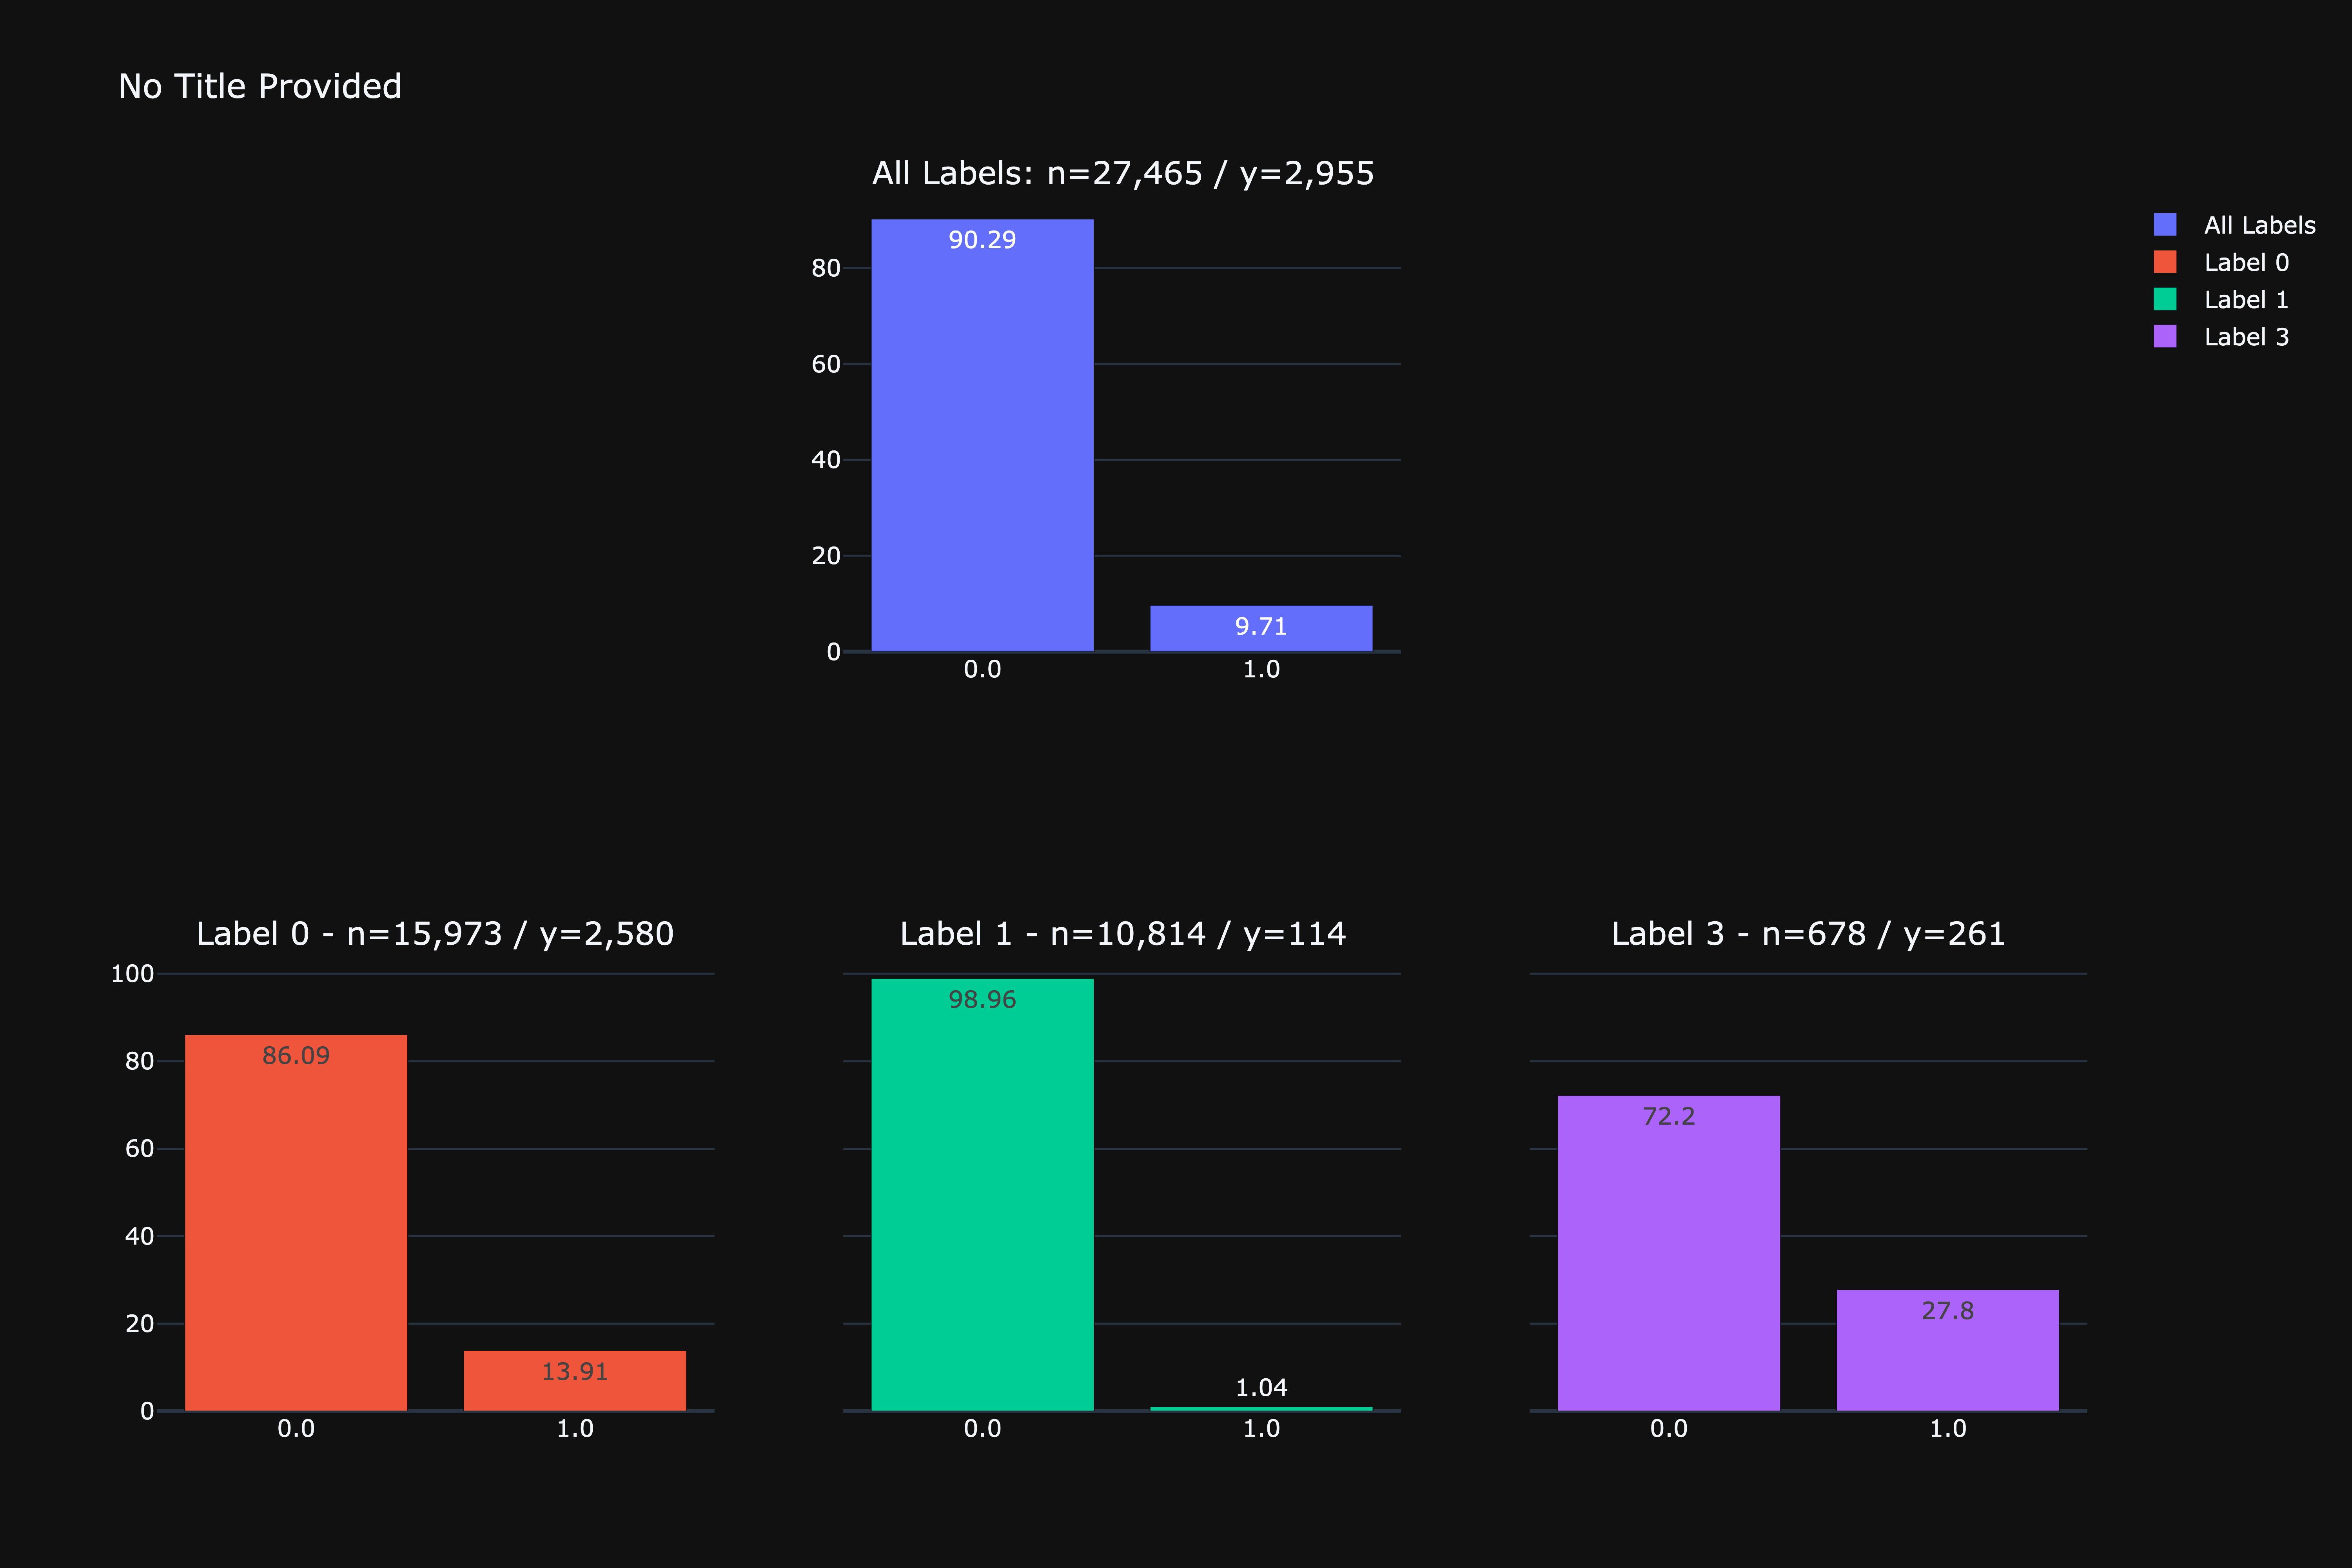

In [75]:
fig = plot_binary_distribution_by_label(df_main, 'is_business_account')
sv.save_plotly_fig(fig)

In [ ]:
px.sunburst(df_main.dropna(subset='category_enum').fillna('na'),
            path=['category_enum', 'category_name'],
            color='label',
            ).update_layout(uniformtext=dict(minsize=10, mode='hide'))

In [ ]:
fig = px.histogram(df_main, 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
sv.save_plotly_fig(fig)

In [ ]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of category_name for bots only')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
sv.save_plotly_fig(fig)

In [ ]:
fig = px.histogram(df_main.query('label > 0'), 
                    x='business_category_name', 
                    color='label',
                    title=f'Distribution of labels for each category of business_category_name for bots and legit users')

fig = fig.update_xaxes(tickangle=-90, categoryorder='total descending') 
sv.save_plotly_fig(fig) 

It's interesting to see the difference between the bots and the sex bots. Even though many have been miss labelled (they'll both be marked at 1 when developping the model) bet ween bot or otherbot, there is a significative distinction between how they identify themselves.

Other bots seems to be more entreupreuners, financial service or investment firm where bots are more video creator (you bet), personnal blog or gamer.

In [ ]:
df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True)[df_main.query('label > 0')['category_name'].value_counts().sort_values(ascending=True).lt(12)].index

In [ ]:
# Keeping only binary columns
df_main = df_main.drop(['category_name', 'business_category_name', 'business_contact_method', 'category_enum', 'should_show_category'], axis=1)

---

In [ ]:
df_main.head()

### 1.9 Binary columns

Here, I'm gonna treat all the binary columns, the one with True/False. Those columns are: 
* has_guides: 
* has_clips
* is_private: The user has a private account (only followers can see their posts)
* is_embeds_disabled: whether the post or media item can be embedded on another website or platform.
* is_joined_recently: whether the user has joined Instagram recently	
* should_show_public_contacts: 

#### 1.9.1 has_guides

whether an Instagram profile has any Guides associated with it or not. Guides are a feature on Instagram that allow users to create and share curated collections of posts and other content, with the goal of providing a more immersive and informative experience around a particular topic.

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'has_guides')
sv.save_plotly_fig(fig)

Almost all of the users don't have any guides. The only legit users have guides but only 1.1% of them which is very low.The column is likely to be very weak predictor, but I'll keep it for now.

#### 1.9.2 has_clips

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'has_clips')
sv.save_plotly_fig(fig)

In here, the data is highly skewed, most of the users don't have any clips but then ones who have the most are the legit users where 26% of them have some. Both other bots have a very low percentage of users having clips.

#### 1.9.3 is_private

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


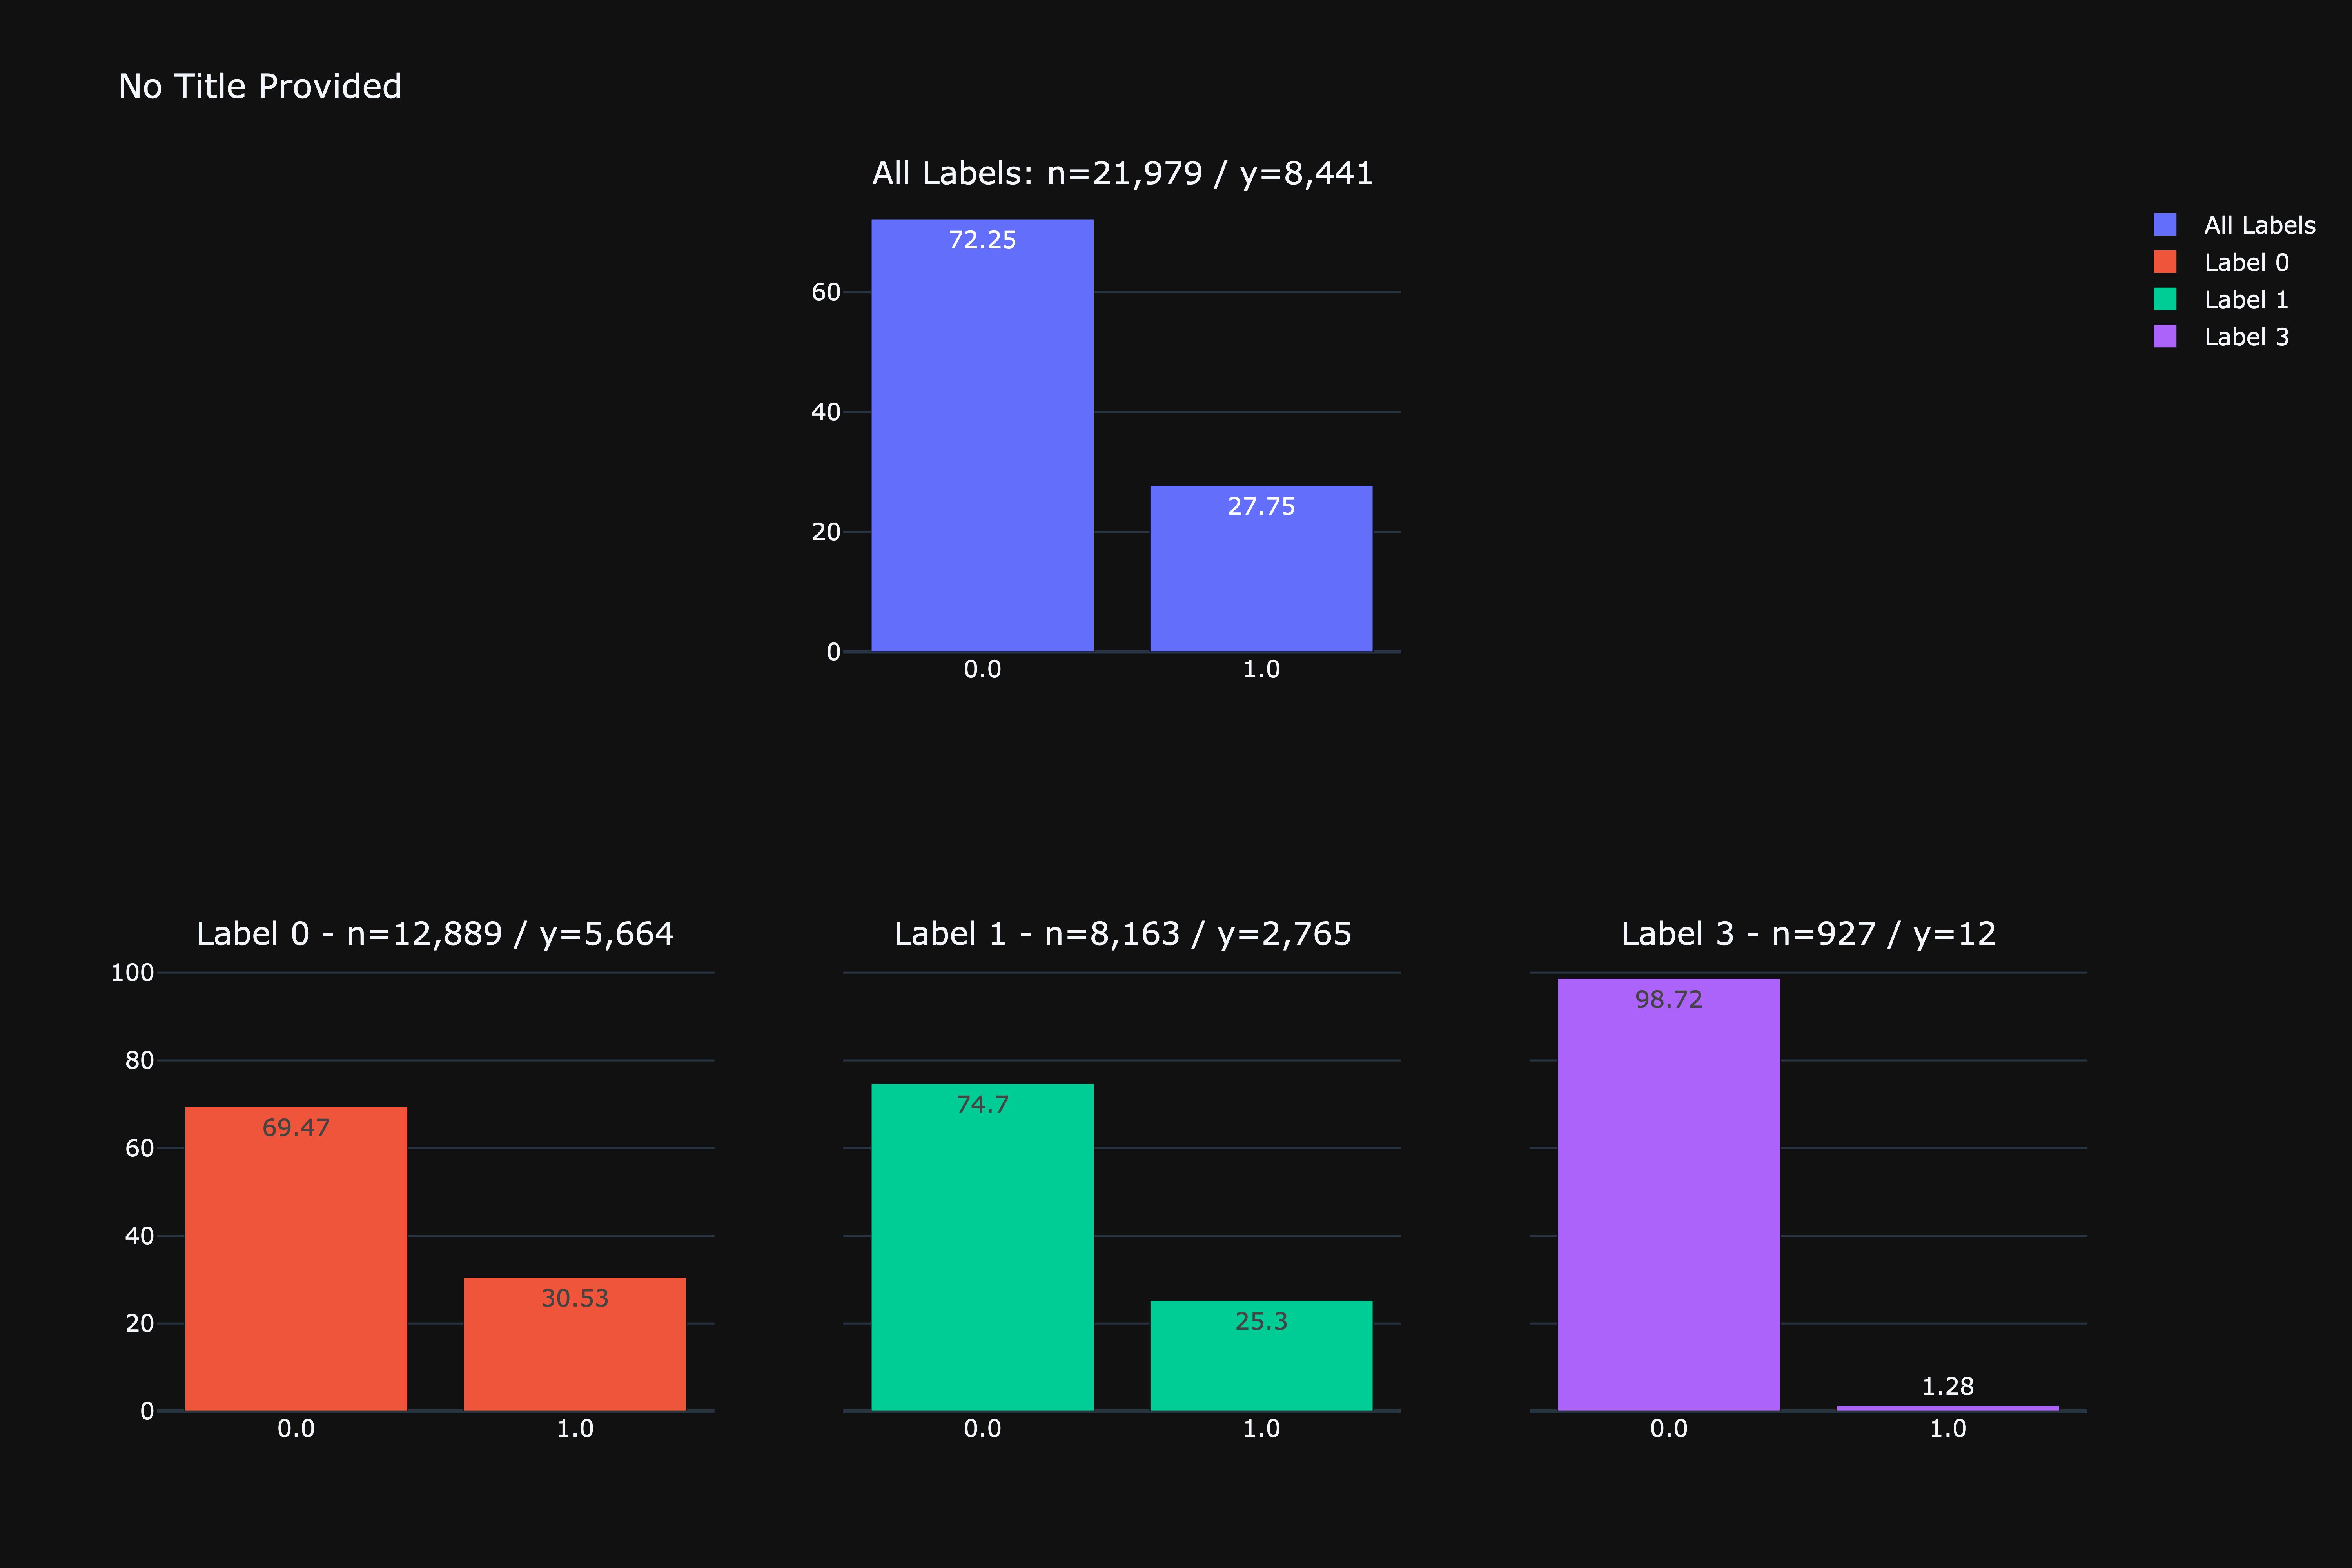

In [73]:
fig = plot_binary_distribution_by_label(df_main, 'is_private')
sv.save_plotly_fig(fig)

Once again, skewed data. Legit users and classic bots have a similar percentage of private accounts, about 25-30% versus a percent for the other bots.

When scraping and looking at the user during the whole project, I found many bots that were private. I wonder what the real reason is 

#### 1.9.4 is_embeds_disabled

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


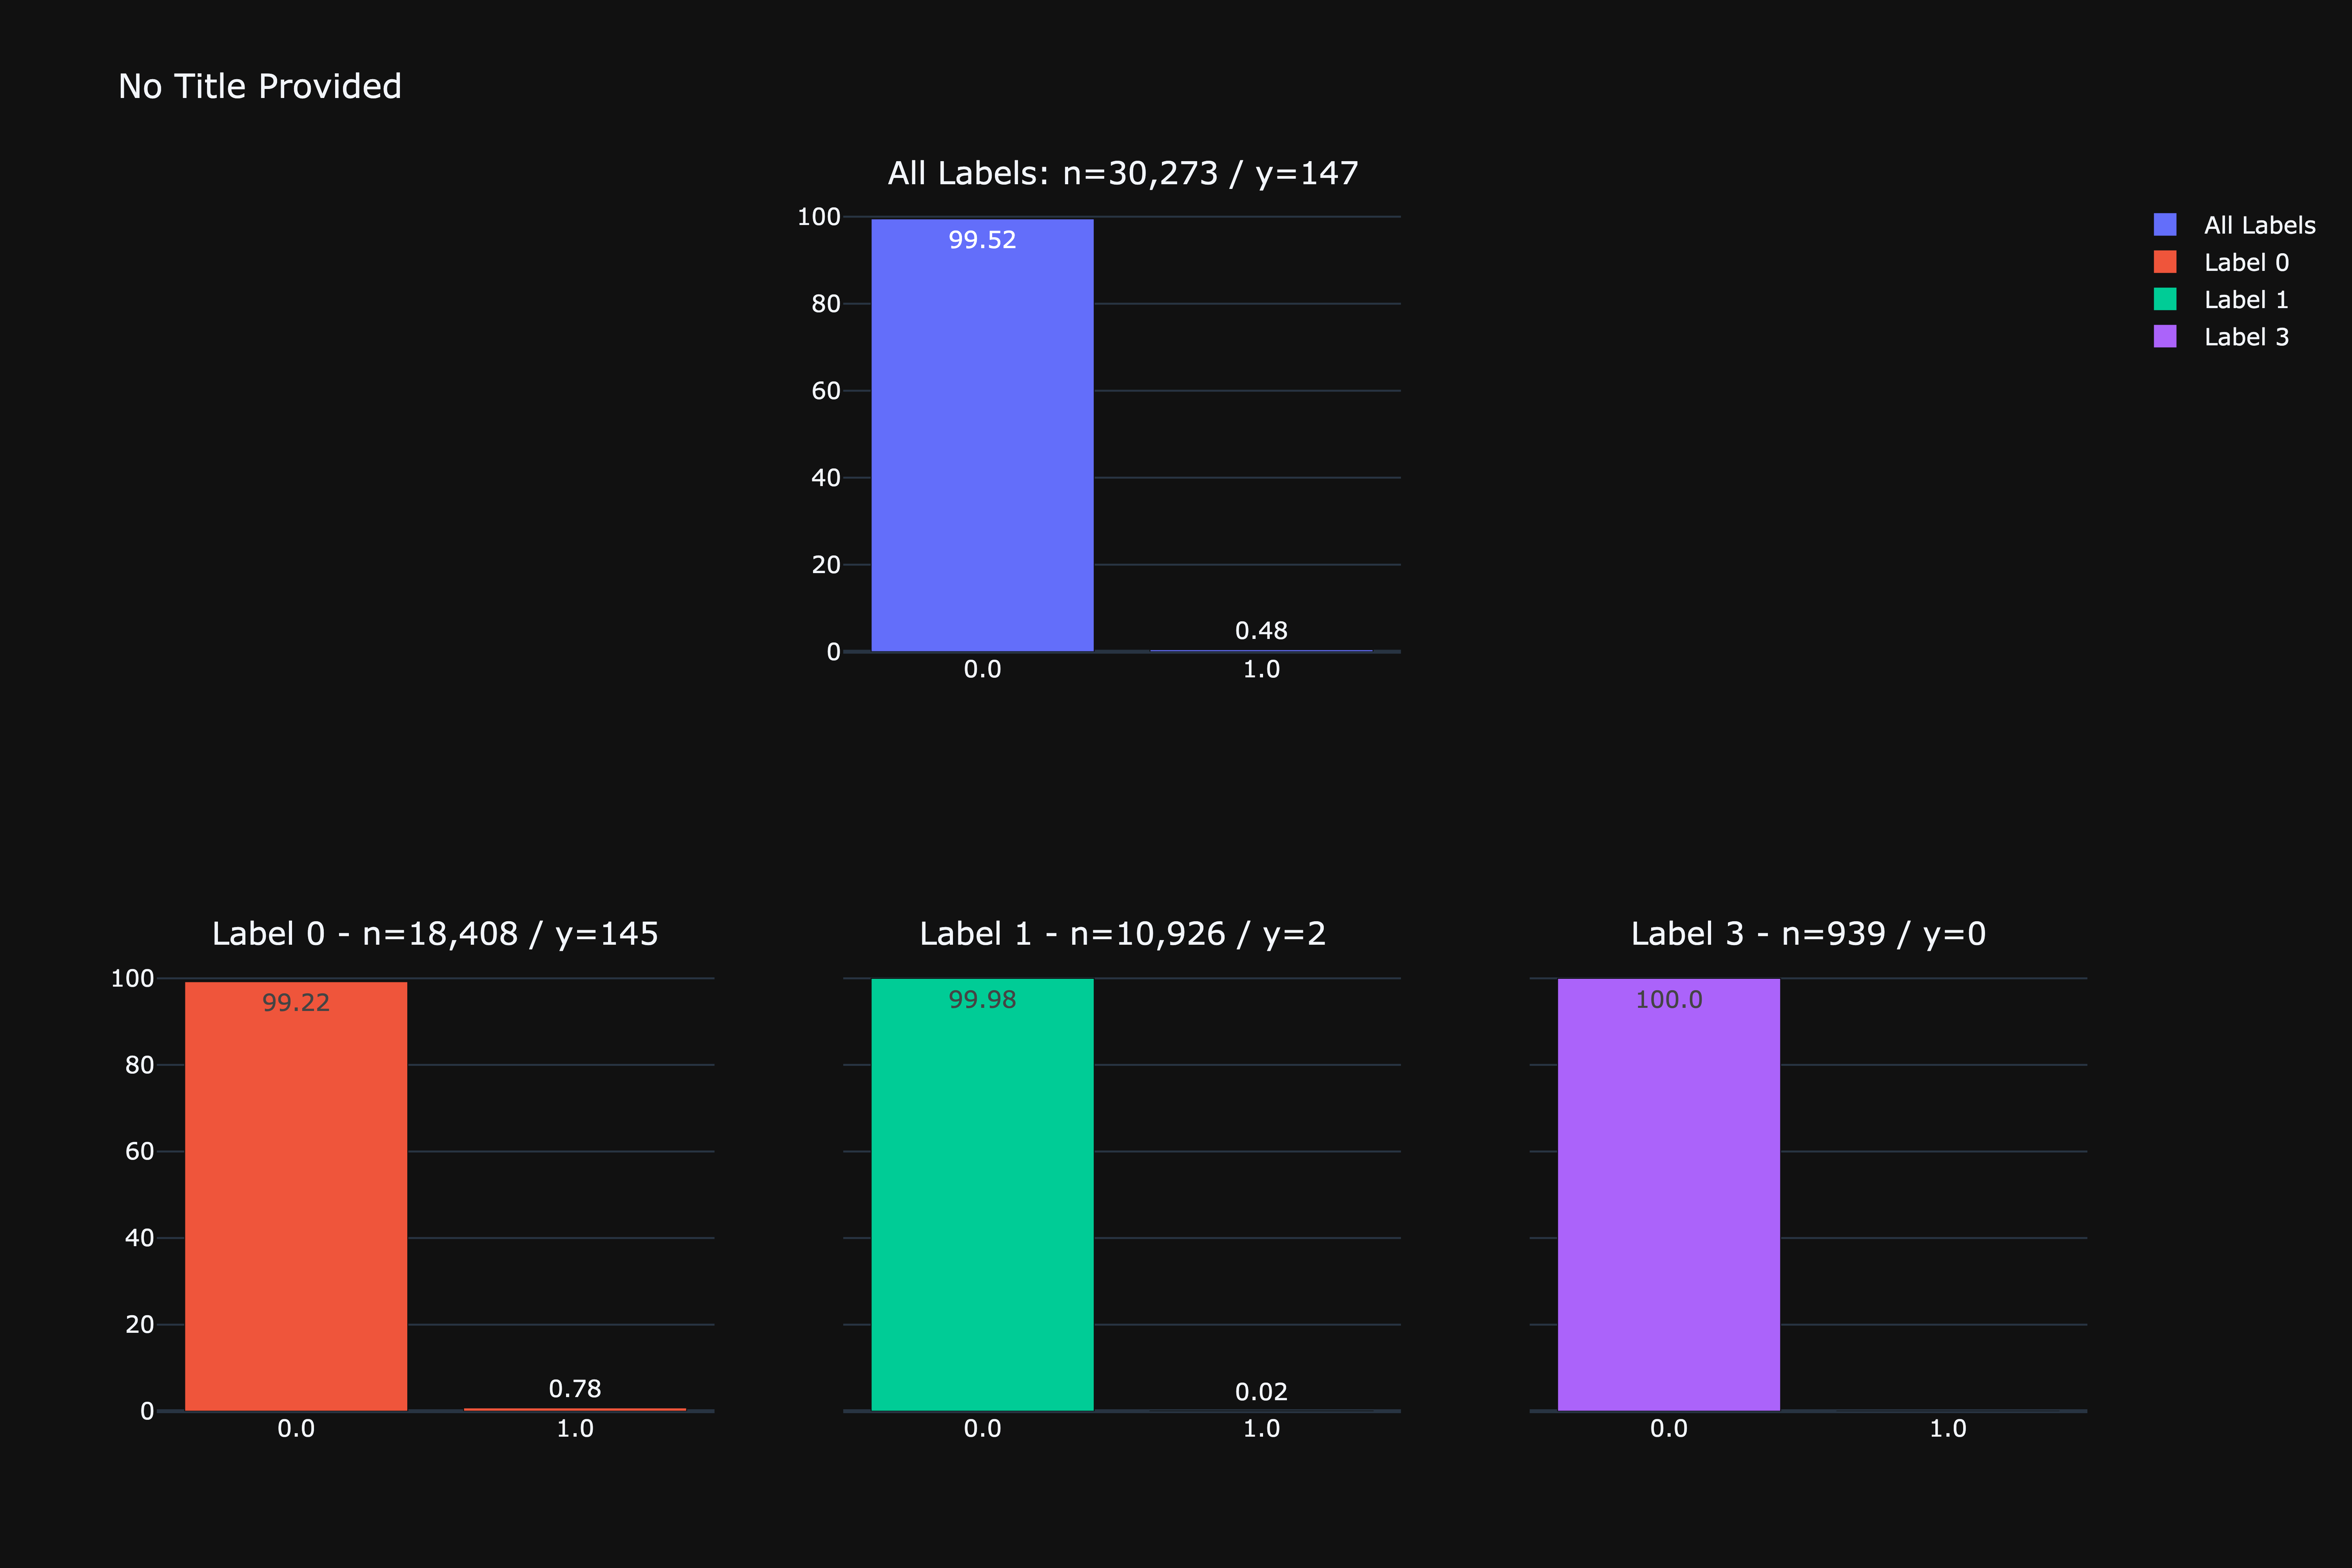

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'is_embeds_disabled')
sv.save_plotly_fig(fig)

This is the most skewed feature of the binary ones, most of the users have embeds enabled. Only a very few users have it disable for some reason.

#### 1.9.5 is_joined_recently

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


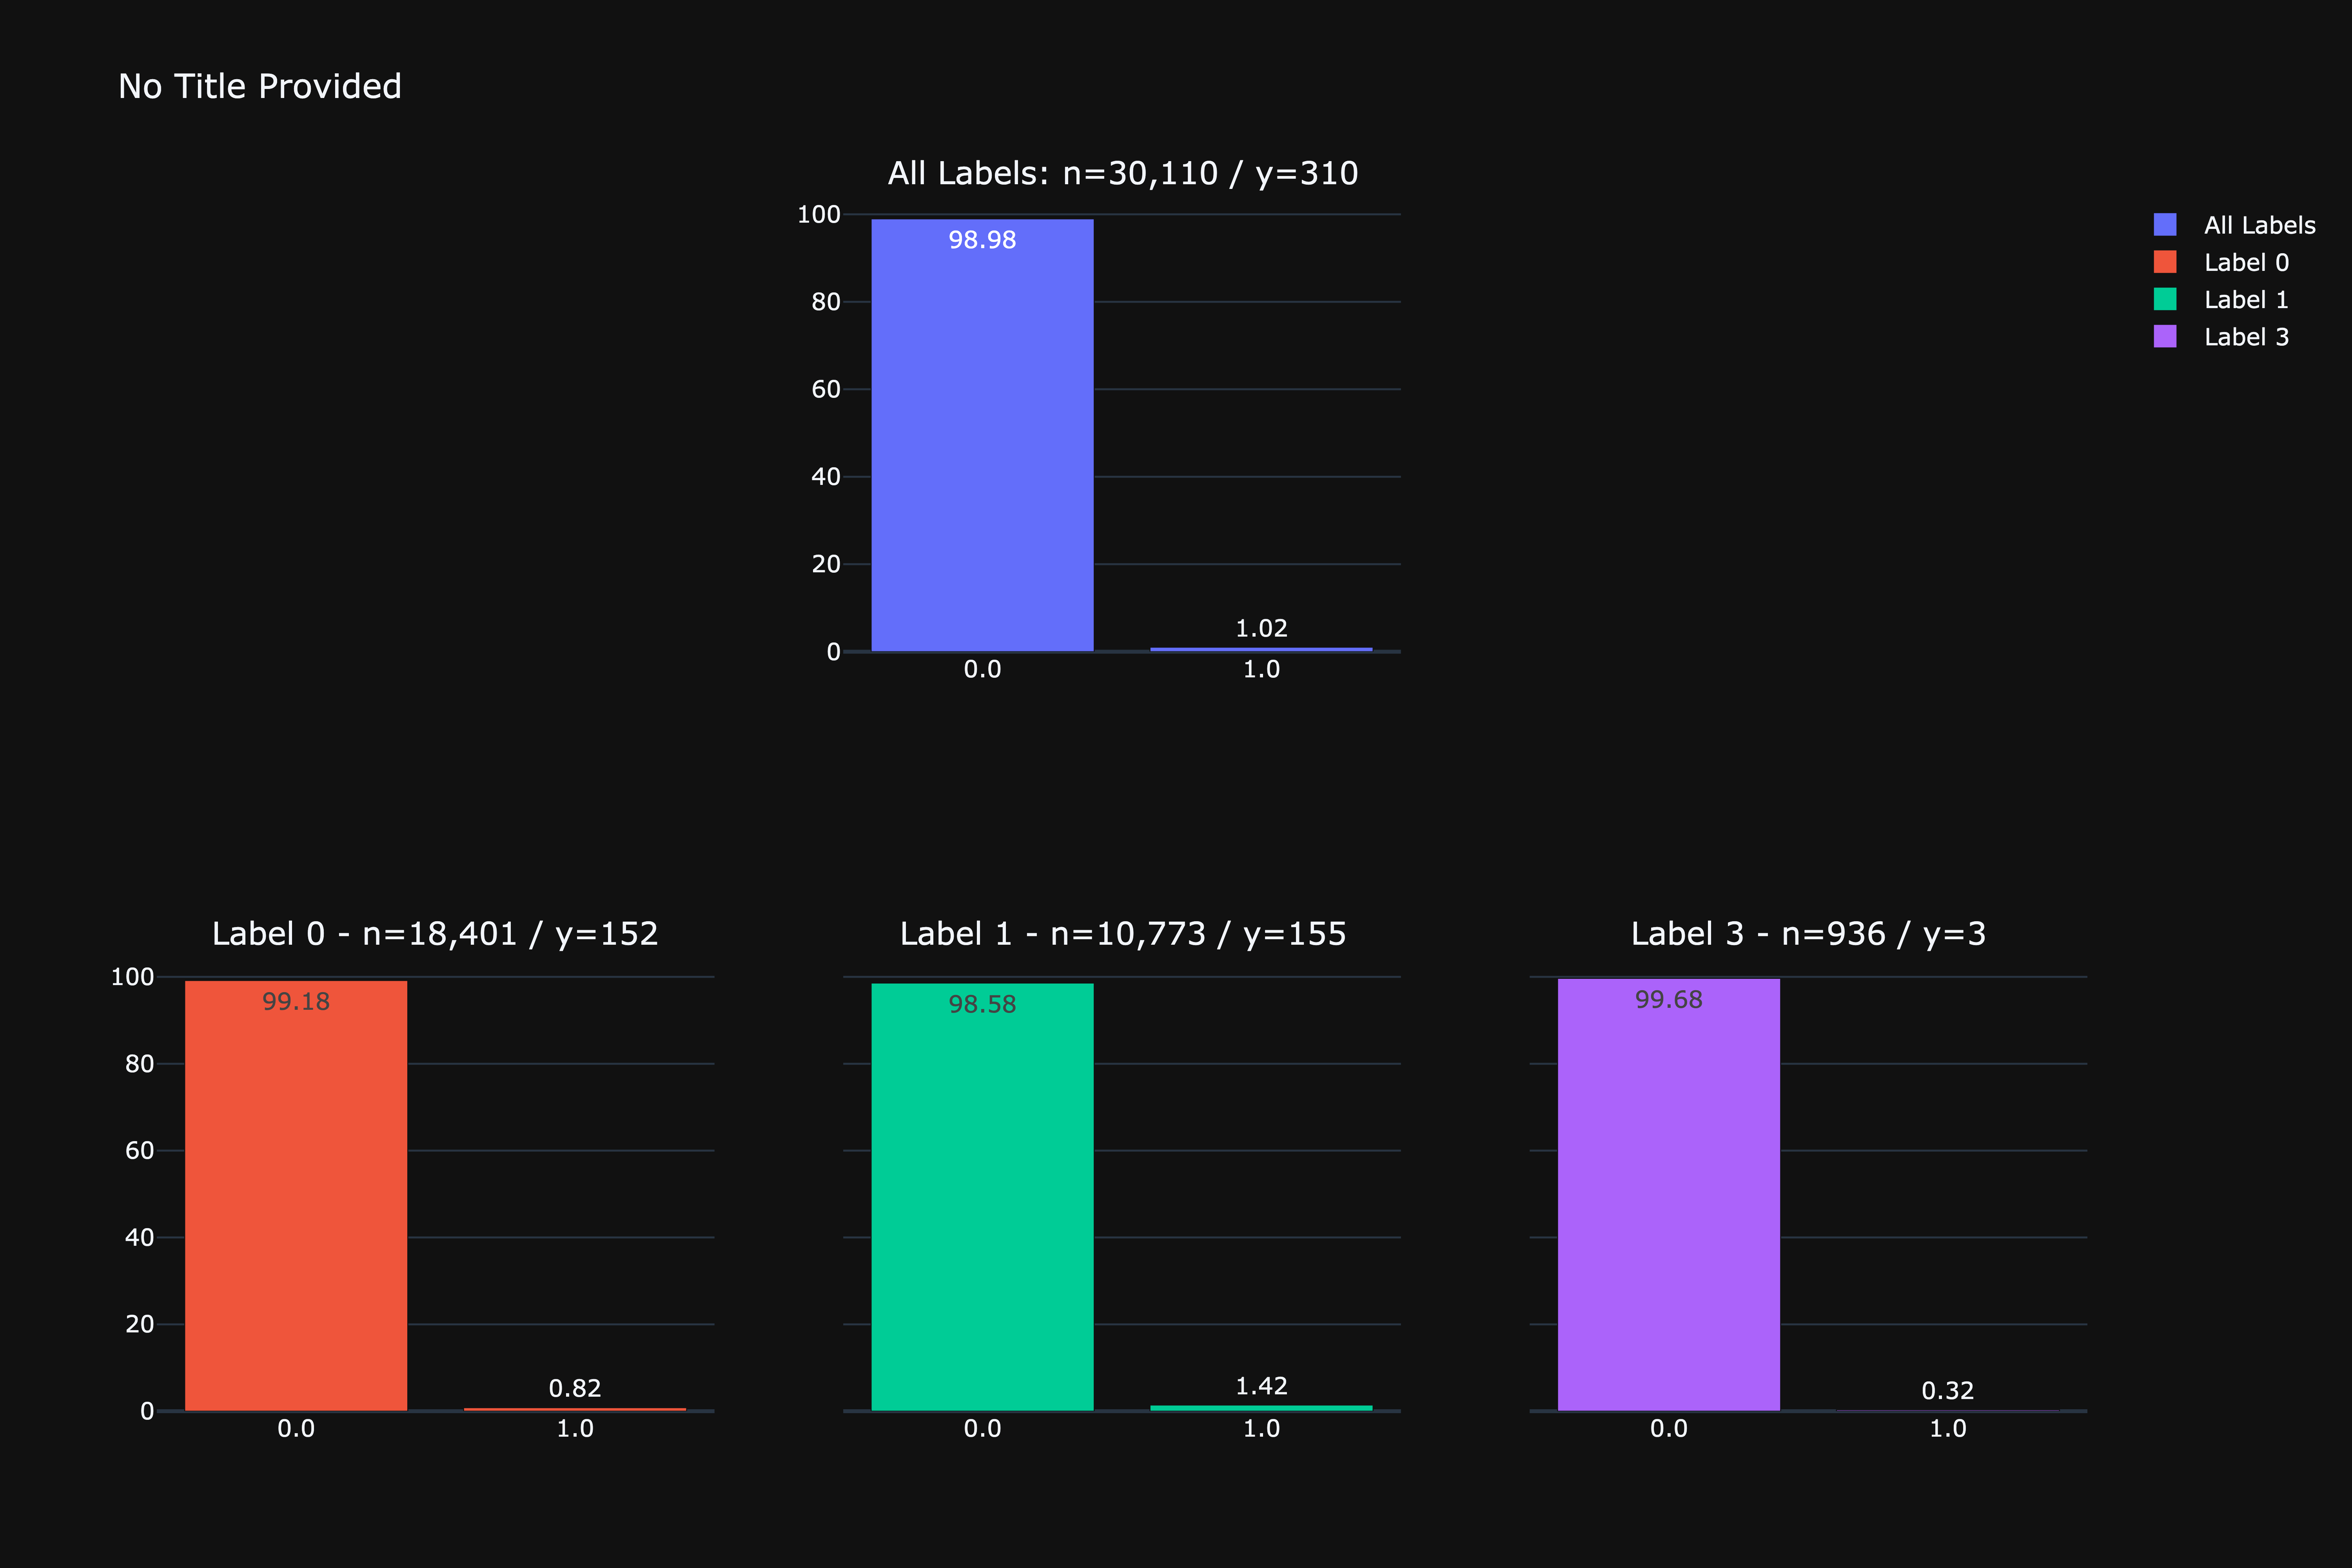

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'is_joined_recently')
sv.save_plotly_fig(fig)

This is the most skewed feature of the binary ones, most of the users have embeds enabled. Only a very few users have it disable for some reason.

#### 1.9.6 should_show_public_contacts

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


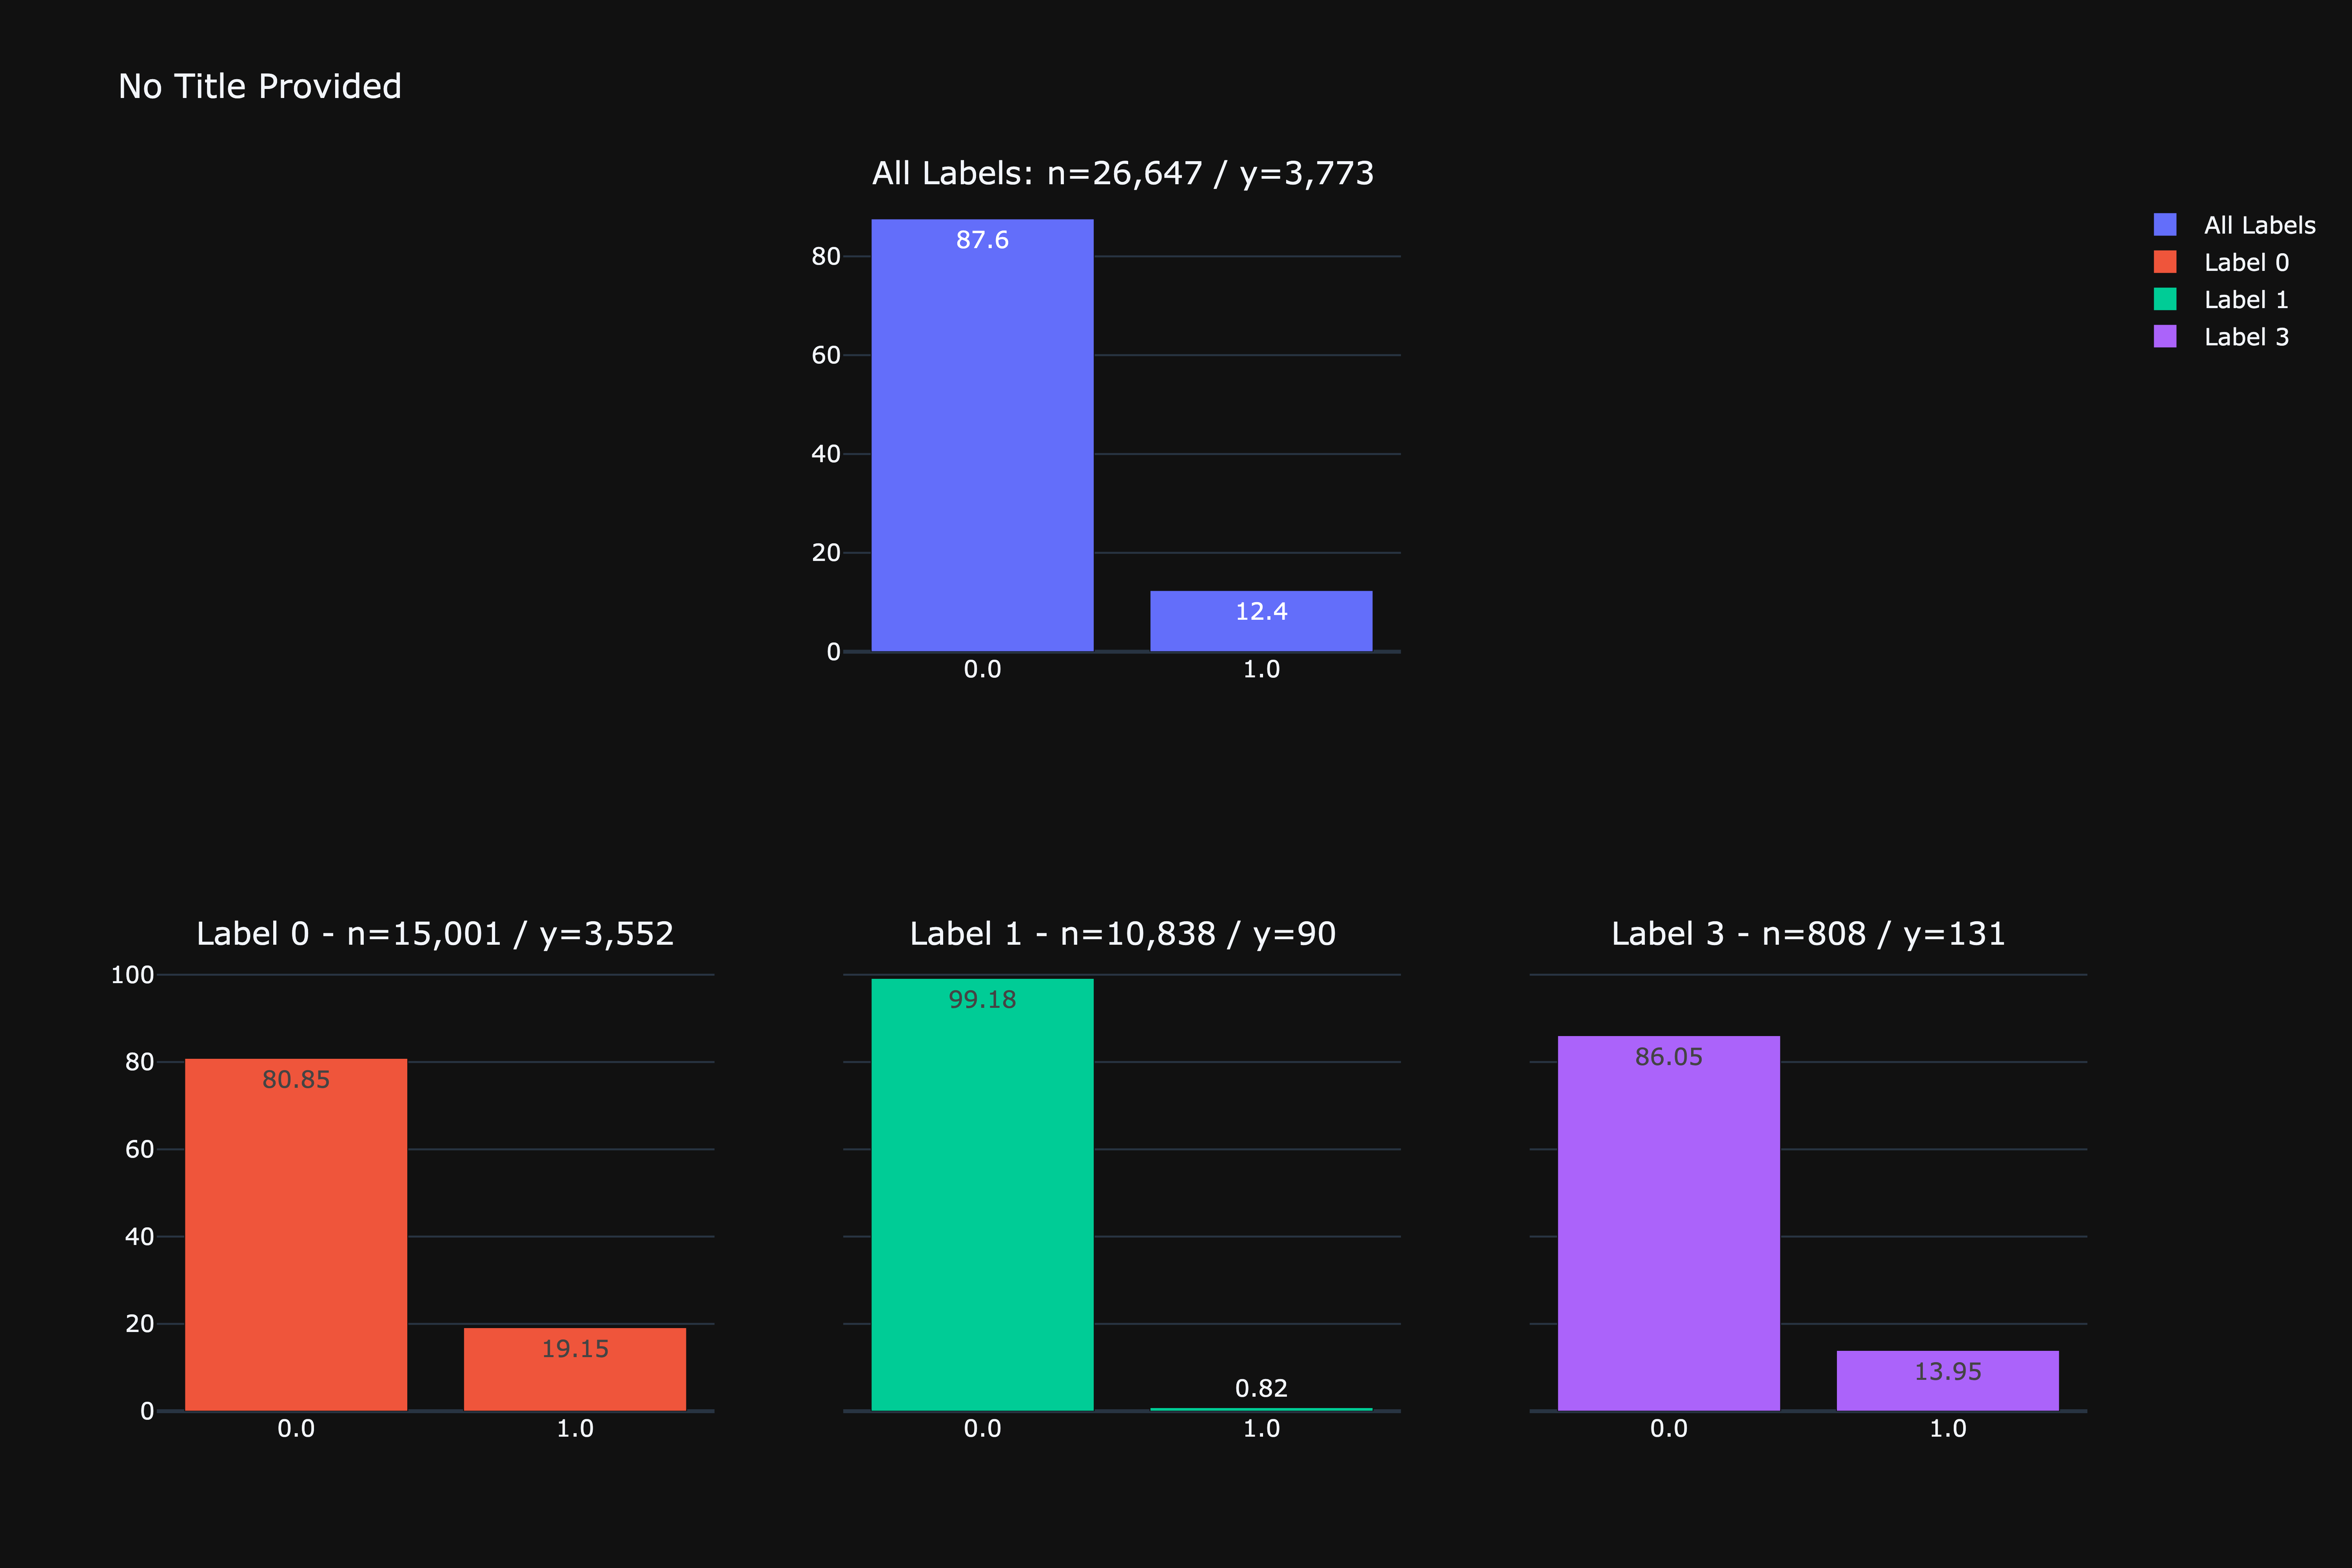

In [ ]:
fig = plot_binary_distribution_by_label(df_main, 'should_show_public_contacts')
sv.save_plotly_fig(fig)

### 1.10 Users' posts list

When collecting users' profile data, Instagram returns by default the last 12 posts of the users. Each posts have multiple attributes like the number of likes, comments, when the post was posted, etc. I'm gonna explore those and see what can I get from them. 

The data is not in a format usable so I'll have to summarize each of the different lists. The process: 
* Count how many posts I have the data on. Some users are private which prevents me from knowing anything about their posts
* Aggregate all the lists to extract new features: 
    * For columns as likes, video_view, comments, I can get the total, mean and median. 
    * For columns as posted time, I can get the difference between first and last posts and average diff between each posts
    * For the caption, I can extract if the user tagged anyone or....???


Im not suer who generated the data for those columns. For the likes on the comments, I knew for a fact that many bots like other's comments. I don't know if that's the case for the likes and comment received by the users on their posts. I'll keep all the columns regardless and see what I can do with them.

In [ ]:
# df_main.to_sql('trash_df_can_del_anytime', con, if_exists='replace', index=False)
df_main = pd.read_sql('select * from trash_df_can_del_anytime', con)

In [ ]:
df_user_posts = df_main[[col for col in df_main if 'posts_concat' in col or col in ['username', 'label', 'binary_label', 'post_count']]].drop_duplicates().dropna()

# Changing the values of the columns to lists
post_cols = ['posts_concat_likes',	'posts_concat_is_video', 'posts_concat_video_views', 'posts_concat_comments', 'posts_concat_posted_time', 'posts_concat_caption']
for col in post_cols: 
    df_user_posts[col] = df_user_posts[col].apply(lambda x: x.split(',') if pd.notna(x) else x)

df_user_posts['posts_fetch_count'] = df_user_posts['posts_concat_likes'].apply(lambda x: len(x) if isinstance(x, list) else x)
df_user_posts[post_cols]

#### 1.10.1 Counting the number of posts & Sum, med, mean

In [ ]:
# def aggregate_posts_col(df, col, agg_func):
#     df = df.explode(col)
#     df = df.groupby('username').agg({col: agg_func}).reset_index().round(2)
#     df.columns = ['_'.join(col).strip() for col in df.columns.values]
#     return df

# df = aggregate_posts_col(df_user_posts[['username', 'posts_concat_likes']], 'posts_concat_likes', ['median', 'min', 'max'])
# df

#### 1.10.2 Time between posts

When starting the project, I assumed that the profiles of the bots are fast to be created meaning when the guys managing the bots create profiles, they post all photos at the same time with the bio and url. A normal user on the other way, doesn't post a lot of photos at the same time, there are always some days of difference between each posts.

In [ ]:
def time_diff_min_max_post (lst): 
    if lst == None: 
        return None
    elif len(lst) == 1: 
        return 0
    lst = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in lst]
    lst.sort(reverse=True)
    return (lst[0] - lst[-1]).total_seconds()

df_user_posts['time_diff_min_max_post_seconds'] = df_user_posts['posts_concat_posted_time'].apply(time_diff_min_max_post)
df_user_posts['time_diff_min_max_post_avg'] = df_user_posts['time_diff_min_max_post_seconds'] / df_user_posts['posts_fetch_count']

sub_df, fig = df_user_posts.describe_column_by_colcat('time_diff_min_max_post_avg')
display(sub_df)
fig

In [ ]:
fig = px.histogram(df_user_posts, 
                   x="time_diff_min_max_post_avg", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the highlight reel count per label',
                   **plotly_kwargs,
                   )


fig = fig.update_layout(barmode='overlay') # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig, 'fig')

My assumption that the bot post all their posts at once was correct, 75% of the bots have an average of 13s between each post they posts for the last 12 collected. Once again, there is a distinction between the sex bots and the other bots that have a much higher average time between each post.

This is very significant and will definitely be a helpful feature to differentiate bot from legit users. 

In [ ]:
bot95q = df_user_posts.query('label == 1')['time_diff_min_max_post_avg'].quantile(.95)
print(f'Bot\'s 95th quantile: {round(bot95q)}')

In [ ]:
# Looking at user who have their avg post time diff greater or equal to 1h. 
conditions = {f'post_count < 2': [],
              f'post_count >= 2': [],
              f'post_count < 2 and label in (0, 1)': [], 
              f'post_count >= 2 and label in (0, 1)': [], 
              }

threshold = 3600 # 1 hour
col = f'time_diff_min_max_post_avg_ge_{threshold}_flag'
df_user_posts[col] = (df_user_posts[f'time_diff_min_max_post_avg'] >= threshold).astype(int)
for condition in conditions.keys():
    sub_df = df_user_posts.query(condition)[['binary_label', col]].copy()
    corr = sub_df.corr().loc[col, 'binary_label']
    conditions[condition] = round(corr, 2)


print(f'Correlation between {col} and binary_label (1 or 0) for users with\n')
print(tabulate(list(conditions.items()), headers=['Condition', 'Correlation']))

It's interesting to see that there is a moderate negative correlation between the time_diff_min_max_post_avg_gt_3600_flag columns and the label for the users with at least 2 posts. The negative correlation is `-0.60` but goes up to `-0.65` when looking at the sex bots only.

In [ ]:
plot_binary_distribution_by_label(df_user_posts.query('post_count >= 2'), 
                                  col, 
                                  title = 'Distributions of the users by labels for the ones with more than 1 post for their avg time between posts is greater or equal to 1h')

In [ ]:
sub_df = df_user_posts.query('post_count < 1')[['binary_label', 'time_diff_min_max_post_avg']].copy()
sub_df['time_diff_flag_bot'] = sub_df['time_diff_min_max_post_avg'] >= 3600 
corr = sub_df.corr().loc['time_diff_flag_bot', 'binary_label']

print(f'Correlation between time_diff_flag_bot and binary_label for users zero or one post: {round(corr, 2)}')

#### 1.10.3 Comments and likes

What's the min max difference compare to the median?

In [ ]:
df_user_posts.explode(col)[col].info()

In [ ]:
# Aggregating the posts likes and comment count columns
for col in ['posts_concat_likes', 'posts_concat_comments']:
    sub_df = df_user_posts.explode(col)
    sub_df[col] = sub_df[col].astype(float).astype(int)
    sub_df = sub_df.groupby('username')[col].agg(['median', 'min', 'max', 'std']).reset_index()
    sub_df.columns = ['username'] + [f'{col}_{metric}' for metric in sub_df.columns][1:]
    sub_df[f'{col}_std'] = sub_df[f'{col}_std'].fillna(0)
    df_user_posts = df_user_posts.merge(sub_df, on='username', how='left')

In [ ]:
sub_df, fig = df_user_posts.describe_column_by_colcat('posts_concat_likes_median')
display(sub_df)
fig

In [ ]:
# number of users with less than 10k likes median
df_user_posts.query('posts_concat_likes_median < 10000').shape, df_user_posts.shape

fig = px.histogram(df_user_posts.query('posts_concat_likes_median < 10000'),
                   x="posts_concat_likes_median", 
                   nbins=1000,
                   color="label",
                   opacity=.8,
                   marginal="box", # or violin, rug
                   title='Distribution of the posts_concat_likes_median (less than 10k) per label',
                   **plotly_kwargs,
                   )


fig = fig.update_layout(barmode='overlay') # Default range is 0, 100 but can be changed to max by double clicking on plolty viz

sv.save_plotly_fig(fig, 'fig')

#### 1.10.4 Video and video views

#### 1.10.5 Caption

#### 1.10.6 Merging back df user posts to df main

In [ ]:
# Adding post columns to df main 
new_columns = [col for col in df_user_posts.columns if col not in df_main.columns] + ['username']
df_main = df_main.merge(df_user_posts[new_columns], on='username', how='left')

# Fixing missing values for users with no posts
df_main['posts_fetch_count'] = df_main['posts_fetch_count'].fillna(0)
df_main[new_columns] = df_main[new_columns].fillna(0)

In [ ]:
# removing posts columns 
df_main = df_main.drop(columns=[col for col in df_main.columns if 'posts_concat_' in col], axis=1)

In [ ]:
df_main.drop(['outlier', 'labelling_technique'], axis=1).to_sql('main_after_univariate', con, if_exists='replace', index=False)

os.system('say "Data Cleaning Done"')

### Done but need to add above
--- 

In [ ]:
# import matplotlib.cm
# cmap = matplotlib.cm.get_cmap('Reds')
def left_subtract(l1,l2):
    lst = []
    for i in l1:
        if i not in l2:
            lst.append(i)
    return lst
def data_suggestions(data):
    """
    Modified by Ram Seshadri. Original idea for data suggestions module was a Kaggler.
    Many thanks to: https://www.kaggle.com/code/itkin16/catboost-on-gpu-baseline
    """
    maxx = []
    minn = []
    all_cols = list(data)
    cat_cols1 = data.select_dtypes(include='object').columns.tolist()
    cat_cols2 = data.select_dtypes(include='category').columns.tolist()
    cat_cols = list(set(cat_cols1+cat_cols2))
    ### The next line may look odd but due to different versions of pandas which
    ### treat the definition of float differently, I am forced to use this. Don't change it.
    num_cols = data.select_dtypes(include='float16').columns.tolist() + data.select_dtypes(
                    include='float32').columns.tolist() + data.select_dtypes(include='float64').columns.tolist()
    non_num_cols = left_subtract(all_cols, num_cols)
    for i in data.columns:
        if i not in cat_cols:
            ### for float and integer, no need to calculate this ##
            minn.append(0)
        else:
            minn.append(data[i].value_counts().min())
    length = len(data)
    nunik = data.nunique()
    nulls = data.isna().sum()
    df = pd.DataFrame(
        {
         #'column': list(data),
        'Nuniques': nunik,
         'NuniquePercent': (100*(nunik/length)),
         'dtype': data.dtypes,
         'Nulls' : nulls,
         'Nullpercent' : 100*(nulls/length),
         'Value counts Min':minn
        },
        columns = ['Nuniques', 'dtype','Nulls','Nullpercent', 'NuniquePercent',
                       'Value counts Min'])
    newcol = 'Data cleaning improvement suggestions'
    print('%s. Complete them before proceeding to ML modeling.' %newcol)
    mixed_cols = [col for col in data.columns if len(data[col].apply(type).value_counts()) > 1]
    df[newcol] = ''
    df['first_comma'] = ''
    if len(cat_cols) > 0:
        mask0 = df['dtype'] == 'object'
        mask1 = df['Value counts Min']/df['Nuniques'] <= 0.05
        mask4 = df['dtype'] == 'category'
        df.loc[mask0&mask1,newcol] += df.loc[mask0&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask4&mask1,newcol] += df.loc[mask4&mask1,'first_comma'] + 'combine rare categories'
        df.loc[mask0&mask1,'first_comma'] = ', '
        df.loc[mask4&mask1,'first_comma'] = ', '
    mask2 = df['Nulls'] > 0
    df.loc[mask2,newcol] += df.loc[mask2,'first_comma'] + 'fill missing'
    df.loc[mask2,'first_comma'] = ", "
    mask3 = df['Nuniques'] == 1
    df.loc[mask3,newcol] += df.loc[mask3,'first_comma'] + 'invariant values: drop'
    df.loc[mask3,'first_comma'] = ", "
    if len(non_num_cols) > 0:
        for x in non_num_cols:
            if df.loc[x, 'NuniquePercent'] == 100:
                df.loc[x, newcol] += df.loc[x,'first_comma'] + 'possible ID column: drop'
                df.loc[x,'first_comma'] = ", "
    mask5 = df['Nullpercent'] >= 90
    df.loc[mask5,newcol] += df.loc[mask5,'first_comma'] + 'very high nulls percent: drop'
    df.loc[mask5,'first_comma'] = ", "
    #### check for infinite values here #####
    inf_cols1 = np.array(num_cols)[[(data.loc[(data[col] == np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols2 = np.array(num_cols)[[(data.loc[(data[col] == -np.inf)]).shape[0]>0 for col in num_cols]].tolist()
    inf_cols = list(set(inf_cols1+inf_cols2))
    ### Check for infinite values in columns #####
    if len(inf_cols) > 0:
        for x in inf_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'infinite values: drop'
            df.loc[x,'first_comma'] = ", "
    #### Check for skewed float columns #######
    skew_cols1 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 1
                    ) & (np.abs(np.round(data[col].skew(), 1)) <= 5) for col in num_cols]].tolist()
    skew_cols2 = np.array(num_cols)[[(np.abs(np.round(data[col].skew(), 1)) > 5) for col in num_cols]].tolist()
    skew_cols = list(set(skew_cols1+skew_cols2))
    ### Check for skewed values in columns #####
    if len(skew_cols1) > 0:
        for x in skew_cols1:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'skewed: cap or drop outliers'
            df.loc[x,'first_comma'] = ", "
    if len(skew_cols2) > 0:
        for x in skew_cols2:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'highly skewed: drop outliers or do box-cox transform'
            df.loc[x,'first_comma'] = ", "
    ##### Do the same for mixed dtype columns - they must be fixed! ##
    if len(mixed_cols) > 0:
        for x in mixed_cols:
            df.loc[x,newcol] += df.loc[x,'first_comma'] + 'fix mixed data types'
            df.loc[x,'first_comma'] = ", "
    df.drop('first_comma', axis=1, inplace=True)
    return df
###################################################################################
def data_cleaning_suggestions(df):
    """
    This is a simple program to give data cleaning and improvement suggestions in class AV.
    Make sure you send in a dataframe. Otherwise, this will give an error.
    """
    if isinstance(df, pd.DataFrame):
        dfx = data_suggestions(df)
        all_rows = dfx.shape[0]
        ax = dfx.head(all_rows)#.style.background_gradient()  
        display(ax);
    else:
        print("Input must be a dataframe. Please check input and try again.")
###################################################################################

In [ ]:
exclude_cols = ['username', 'biography', 'follow_count'] + [col for col in df_main.columns if isinstance(df_main.loc[0, col], (dict, list))]
data_cleaning_suggestions(df_main.select_dtypes(include=['int', 'float']))

In [ ]:
asdf

## Above this is new clean code and markdown formatting where below is old code kinda eh formatted

### 
---

### Investigate

In [ ]:
# adsf

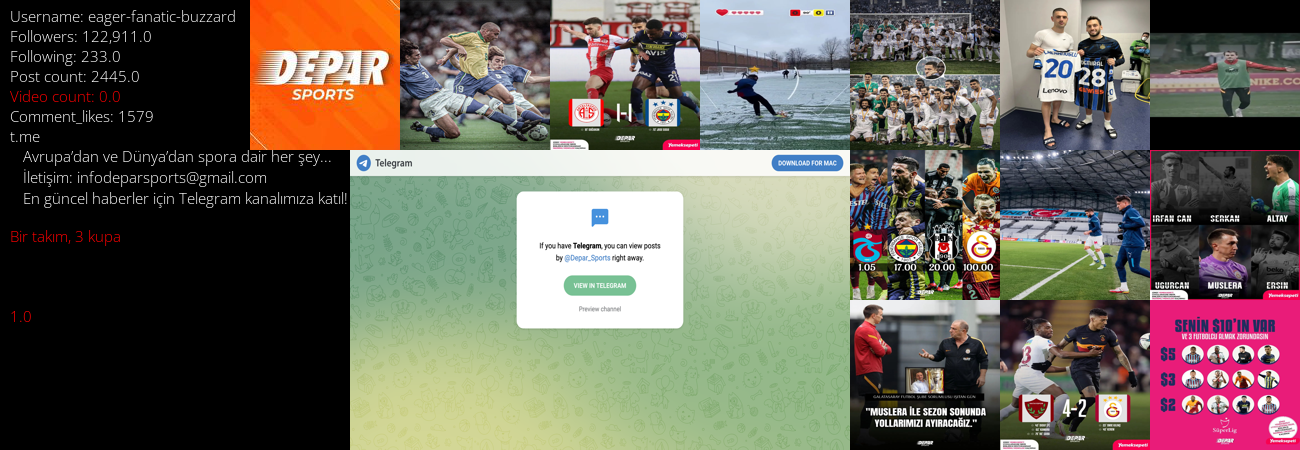

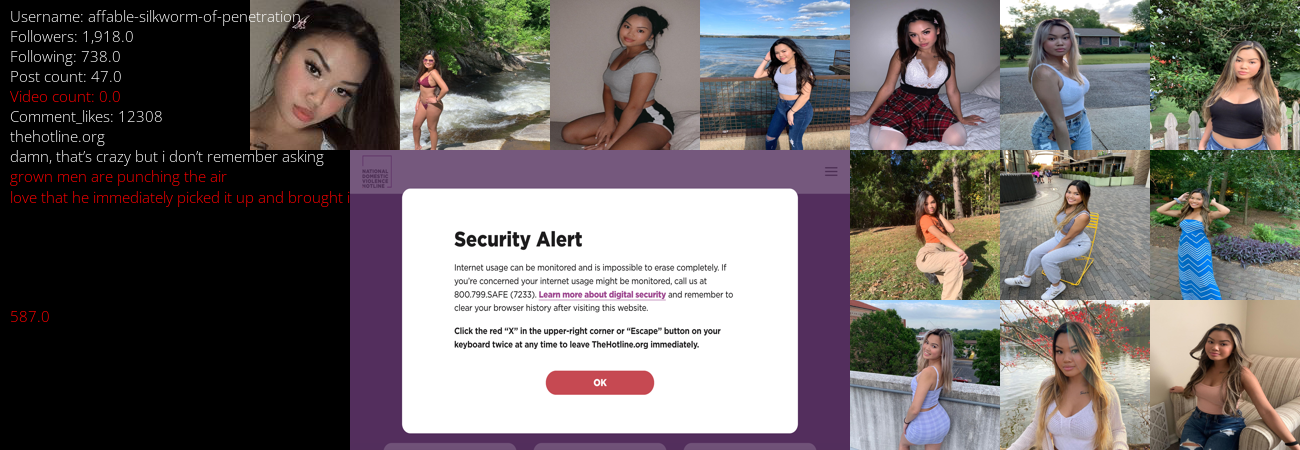

/Users/marclamy/Desktop/code/Instagram_bot_classification/data/photos/temprary_user_summary/


In [107]:
usernames = df_main.query('comment_likes > 1000 and label == 1')['username']
# df_main_bu.query('username in @usernames')
sl.show_user_summary(usernames=usernames)
# usernames

In [105]:
df_main.query('comment_likes > 1000 and label == 1')

username  biography_emoji_count  \
5025             eager-fanatic-buzzard                    4.0   
10934  affable-silkworm-of-penetration                    0.0   
27388  affable-silkworm-of-penetration                    0.0   

       biography_emoji_count_distinct  follow_count  follower_count  \
5025                              4.0         233.0       122,911.0   
10934                             0.0         738.0         1,918.0   
27388                             0.0         738.0         1,918.0   

       comment_emoji_count  comment_emoji_count_distinct  \
5025                     2                             2   
10934                    1                             1   
27388                    2                             2   

       comment_time_difference  comment_likes  post_count  video_count  \
5025                        70           1579     2,445.0          0.0   
10934                      353          13754        47.0          0.0   
27388                      181          10861        47.0          0.0   

       highlight_reel_count  hide_like_and_view_counts  has_guides  has_clips  \
5025                    4.0                        0.0         0.0        1.0   
10934                   1.0                        0.0         0.0        1.0   
27388                   1.0                        0.0         0.0        1.0   

       is_private  is_embeds_disabled  is_joined_recently  \
5025          0.0                 0.0                 0.0   
10934         0.0                 0.0                 0.0   
27388         0.0                 0.0                 0.0   

       is_professional_account  is_business_account  \
5025                       1.0                  0.0   
10934                      1.0                  1.0   
27388                      1.0                  1.0   

       should_show_public_contacts label  binary_label  comment_grams_count  \
5025                           0.0     1             1                    0   
10934                          1.0     1             1                    0   
27388                          1.0     1             1                    0   

       comment_length  comment_word_count  biography_grams_count  \
5025               20                   5                      0   
10934              32                   7                      0   
27388              67                  14                      0   

       biography_length  biography_word_count  biography_linebreak_count  \
5025                141                    18                          3   
10934                46                     8                          0   
27388                46                     8                          0   

       pronouns_na_flag  domain_na_flag  domain_associations_religieuses  \
5025                  1               0                                0   
10934                 1               0                                0   
27388                 1               0                                0   

       domain_shopping  domain_social_networks  domain_shortener  \
5025                 0                       0                 0   
10934                0                       0                 0   
27388                0                       0                 0   

       domain_press  domain_malware  domain_sports  domain_crypto  \
5025              0               0              0              0   
10934             0               0              0              0   
27388             0               0              0              0   

       domain_audio-video  domain_webmail  domain_phishing  domain_None  \
5025                    0               0                0            0   
10934                   0               0                0            0   
27388                   0               0                0            0   

       posts_fetch_count  time_diff_min_max_post_seconds  \
5025                12.0                    

In [ ]:
column = 'comment_likes'

# display(df_main.head(50))
username = 'unselfish-tangible-silkworm'
# print(sl.load_table('select '))
# print(username)

display(sl.load_labels(include_all=True).query('username == @username'))
# display(sl.load_table('username_mapping').query('cooler_name == @username'))
# df_main.query('username == @username')


# sub_df.query('comment_likes > 1000 and label > 0')
df_main_bu.query('username == @username')

In [ ]:
# df_main.query('biography.str.contains("skate") and label > 0')

In [ ]:
# df_main.query('username == "axiomatic-merciful-mayfly"')

### Done investigating

### 
---

## 2.0 Multi variate analysis - Past this point the data is entirely clean and ready for ML.

Questions to answer:
* Try to see for how long the bot profile have existed (number of followers? posts?) against private. Is it because they live too long that they go private to not be banned?
* Check the correlation of features with embed enabled






---



1. `username`: The unique username of the Instagram user.
2. `biography_emoji_count`: The total number of emojis used in the user's biography.
3. `biography_emoji_count_distinct`: The number of distinct emojis used in the user's biography.
4. `follow_count`: The number of users the Instagram user is following.
5. `follower_count`: The number of followers the Instagram user has.
6. `comment_emoji_count`: The total number of emojis used in the user's comments.
7. `comment_emoji_count_distinct`: The number of distinct emojis used in the user's comments.
8. `comment_time_difference`: The time difference between consecutive comments made by the user.
9. `comment_likes`: The number of likes on the user's comments.
10. `post_count`: The total number of posts (images and videos) shared by the user.
11. `video_count`: The total number of videos shared by the user.
12. `highlight_reel_count`: The number of highlight reels created by the user.
13. `hide_like_and_view_counts`: A boolean indicating if the user has chosen to hide their like and view counts.
14. `has_guides`: A boolean indicating if the user has created any Instagram Guides.
15. `has_clips`: A boolean indicating if the user has created any Instagram Clips (short videos).
16. `is_private`: A boolean indicating if the user's account is set to private.
17. `is_embeds_disabled`: A boolean indicating if the user has disabled embedding their content on external websites.
18. `is_joined_recently`: A boolean indicating if the user has joined Instagram recently.
19. `is_professional_account`: A boolean indicating if the user has a professional account.
20. `is_business_account`: A boolean indicating if the user has a business account.
21. `should_show_public_contacts`: A boolean indicating if the user's public contact information should be displayed.
22. `label`: A categorical label assigned to the user based on their activity or account type.
23. `binary_label`: A binary label indicating a specific characteristic or behavior of the user.
24. `comment_grams_count`: The number of n-grams in the user's comments.
25. `comment_length`: The total length of the user's comments (in characters).
26. `comment_word_count`: The total word count in the user's comments.
27. `biography_grams_count`: The number of n-grams in the user's biography.
28. `biography_length`: The total length of the user's biography (in characters).
29. `biography_word_count`: The total word count in the user's biography.
30. `biography_linebreak_count`: The number of line breaks in the user's biography.
31. `pronouns_na_flag`: A boolean indicating if the user has not provided any pronouns in their biography.
32. `domain_na_flag`: A boolean indicating if the user has not provided a domain in their account.
33-43. `domain_*`: Various categorical flags indicating the type of domain associated with the user's account (e.g., `domain_shopping`, `domain_social_networks`, `domain_sports`, etc.).
44. `posts_fetch_count`: The number of posts fetched for analysis.
45. `time_diff_min_max_post_seconds`: The time difference between the user's first and last posts, in seconds.
46. `time_diff_min_max_post_avg`: The average time difference between the user's consecutive posts, in seconds.
47. `time_diff_min_max_post_avg_ge_3600_flag`: A boolean indicating if the average time difference between consecutive posts is greater than or equal to 3600 seconds (1 hour).

In [85]:
df_main = pd.read_sql_query('select * from main_after_univariate', con)
df_main['label'] = df_main['label'].astype('category')
df_main.select_dtypes(exclude=['int', 'float'])

username label
0                adorable-jade-beluga     0
1           hysterical-glistening-bee     0
2                  little-crafty-mink     0
3                 gentle-crimson-wolf     0
4                festive-uppish-leech     0
...                               ...   ...
30415      attentive-mongoose-of-hail     0
30416    resourceful-thistle-toucanet     0
30417           glorious-zippy-agouti     1
30418  hopping-stallion-of-conversion     1
30419            loud-nondescript-elk     0

[30420 rows x 2 columns]

In [86]:
df_main['time_diff_min_max_post_avg'].value_counts()

0.0                     12745
526,032.0833333334        155
111,600.75                 92
16.0                       81
68.16666666666667          75
                        ...  
4,925,306.666666667         1
5,047,879.7                 1
3,991,486.5833333335        1
996,280.2                   1
64,240.083333333336         1
Name: time_diff_min_max_post_avg, Length: 7078, dtype: int64

### 2.1 Correlation

In [87]:
min_corr = -0.3
max_corr = 0.3

corr_matrix = df_main.corr(numeric_only=True)
mask = (corr_matrix <= min_corr) | (corr_matrix >= max_corr)
cols_to_keep = mask.sum()[mask.sum().gt(1)].index
df_corr = corr_matrix.loc[cols_to_keep, cols_to_keep]
fig = px.imshow(df_corr, zmax=.3, zmin=-.3)
fig.write_html('corr_matrix.html')

In [88]:
# Calculate the correlation matrix
corr_matrix = df_main.corr(numeric_only=True)

# Set the diagonal elements to 0
np.fill_diagonal(corr_matrix.values, 0)

# Set a threshold for the correlation coefficient
threshold = 0.4

# Find the most important correlations
important_correlations = corr_matrix[(corr_matrix.abs() >= threshold)].stack().reset_index()
important_correlations.columns = ['feature1', 'feature2', 'correlation']
important_correlations = important_correlations[important_correlations['feature1'] < important_correlations['feature2']].sort_values(by='correlation', ascending=False)

# Display the important correlations
important_correlations = important_correlations.query('feature1.str.split("_").str[0] != feature2.str.split("_").str[0]') # removing similar columns
important_correlations.style.background_gradient(subset=['correlation'])

In [89]:
# Group the dataset by 'label' and calculate the correlation matrix for each group
grouped_corr_matrix = df_main.groupby('label').apply(lambda group: group.corr(numeric_only=True))

# Set the diagonal elements to 0 for each group
for label in df_main['label'].unique():
    np.fill_diagonal(grouped_corr_matrix.loc[label].values, 0)

# Find the important correlations for each group
grouped_important_correlations = {}
for label in df_main['label'].unique():
    important_corr = grouped_corr_matrix.loc[label][(grouped_corr_matrix.loc[label].abs() >= threshold)].stack().reset_index()
    important_corr.columns = ['feature1', 'feature2', 'correlation']
    important_corr = important_corr[important_corr['feature1'] < important_corr['feature2']].sort_values(by='correlation', ascending=False)
    important_corr = important_corr.query('feature1.str.split("_").str[0] != feature2.str.split("_").str[0]')  # removing similar columns
    grouped_important_correlations[label] = important_corr

# Display the important correlations for each group
for label, corr_df in grouped_important_correlations.items():
    print(f"Important correlations for label = {label}:")
    display(corr_df.style.background_gradient(subset=['correlation']))

Important correlations for label = 0:


Important correlations for label = 1:


Important correlations for label = 3:


### 2.x Comment time diff

In [111]:
px.scatter(df_main.query('comment_time_difference < 70111 and comment_likes < 1000'), 
           x='comment_time_difference',
           y='comment_likes',
           color='label', 
           title='Comment Time Difference vs Comment Likes<br><sub>(comment_time_difference < 70111 and comment_likes < 1000)')

### Domain na flag

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/no_title_provided.html


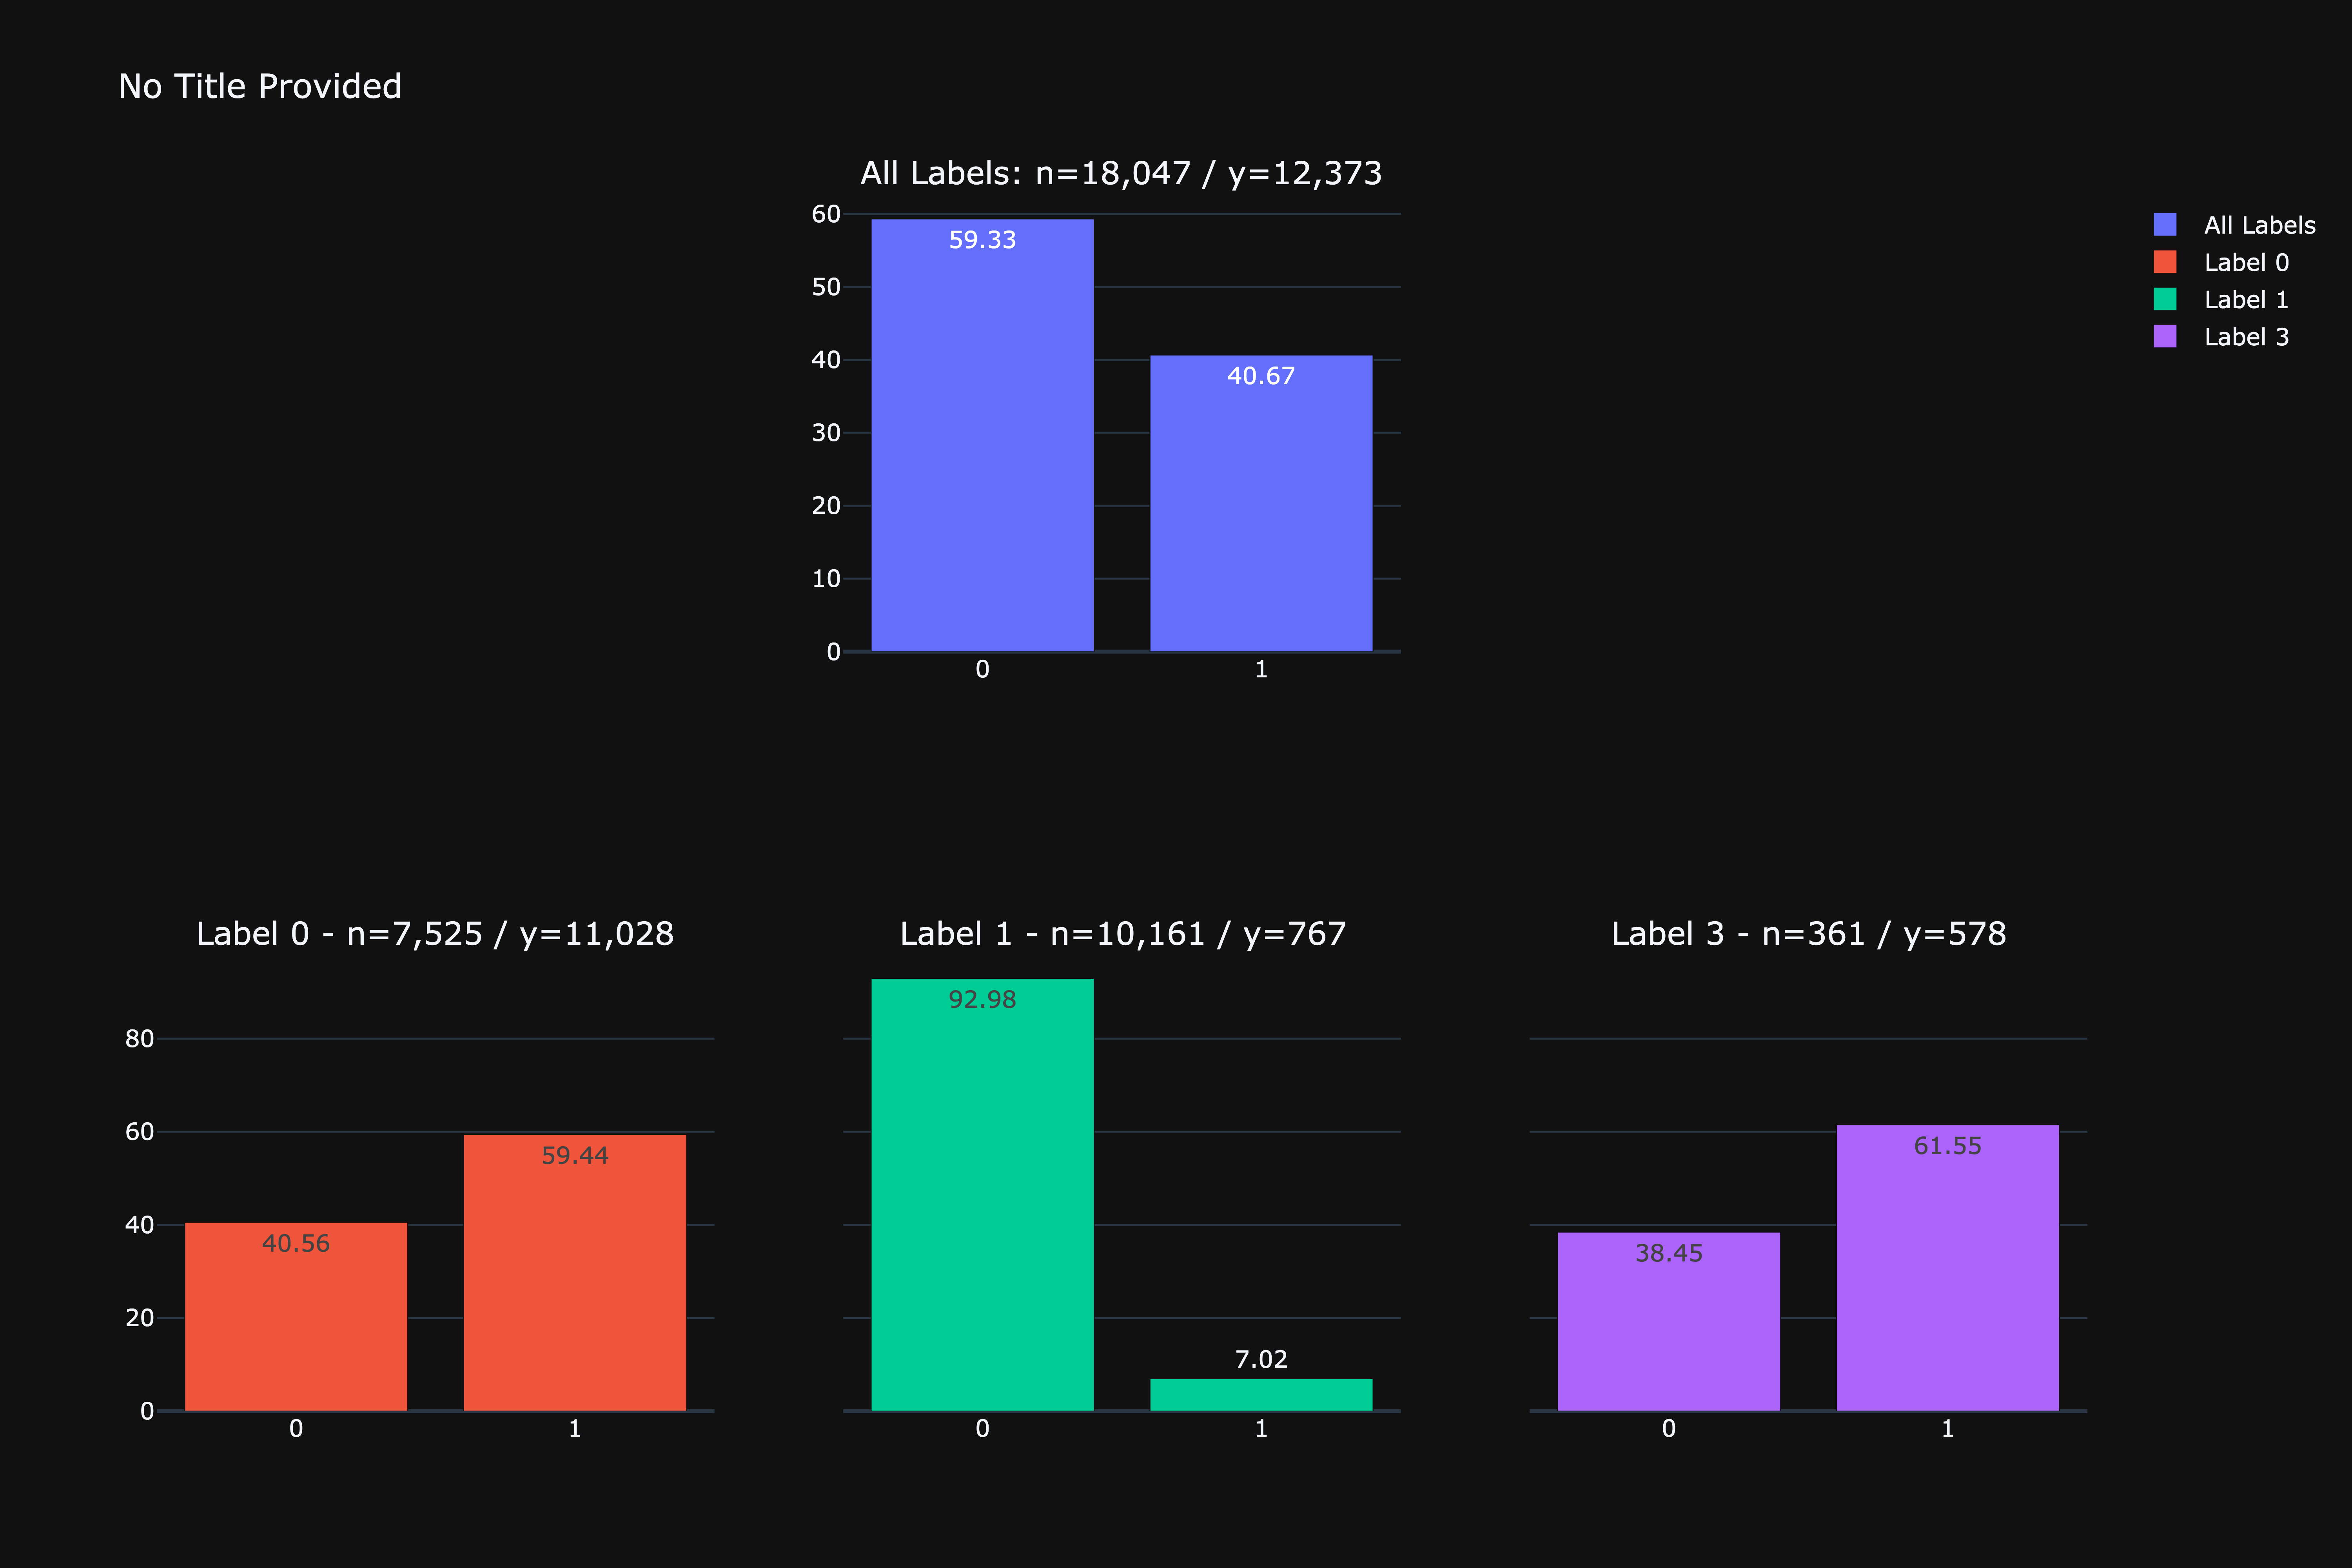

In [92]:
fig = plot_binary_distribution_by_label(df_main, 'domain_na_flag')
sv.save_plotly_fig(fig) 

# Playground

## Export df_ml

In [93]:
os.system("say 'about to export to df ml'")
aksldfj

NameError: name 'aksldfj' is not defined

In [ ]:
df_ml = df_main.copy(deep=True)

df_ml['label'].value_counts()
df_ml.isna().sum().tail(40)
s = df_ml.isna().sum().head(50).eq(0)
cols = s[s].index
cols
df_ml.to_sql('ml', con, if_exists='replace', index=False)